
# **Useful imports**

In [1]:
%cp -r /content/drive/MyDrive/IRTM-2/ .

!pip install --upgrade gensim
!pip install pyphen
!pip install pronouncing
!pip install gensim
!pip install tensorflow-addons
!pip install textstat
!pip install transformers
!pip install pronouncing
!pip install more-itertools
!pip install catboost
!pip install -U sentence-transformers

import time
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt
import cv2
import zipfile
import PIL
import sklearn
import sklearn.metrics
import string
import json
import nltk
import re
import pyphen
import pronouncing
import textstat
import pronouncing
import transformers
import gensim 
import gensim.downloader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier
from more_itertools import chunked
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
from sklearn.metrics import accuracy_score
from datetime import datetime
from collections import Counter

nltk.download('stopwords')
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')

ENGLISH_STOPWORDS = set(stopwords.words('english'))
STEMMER = SnowballStemmer("english")
SYLLABLES_SPLITTER = pyphen.Pyphen(lang='en')
PUNCTUATION = set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# **Data Preprocessing**

Load the datasets and shuffle the data

In [2]:
CORPUS_LOCATION = "/content/IRTM-2/"

train_df = pd.read_csv(os.path.join(CORPUS_LOCATION, "Lyrics-Genre-Train.csv"), usecols=["Lyrics", "Genre"], dtype={"Lyrics": str, "Genre": str})
test_df = pd.read_csv(os.path.join(CORPUS_LOCATION, "Lyrics-Genre-Test-GroundTruth.csv"), usecols=["Lyrics", "Genre"], dtype={"Lyrics": str, "Genre": str})

# Shuffle the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Drop NA
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Remove empty lyrics (or full of whitespaces)
train_df = train_df[train_df["Lyrics"].apply(lambda text: len(text.strip()) > 0)] 
test_df = test_df[test_df["Lyrics"].apply(lambda text: len(text.strip()) > 0)]

print("#### Train DataFrame ####\n")
print(train_df)
print("#########################\n")
print("#### Test DataFrame ####\n")
print(test_df)
print("########################\n")

#### Train DataFrame ####

            Genre                                             Lyrics
0         Hip-Hop  (INTRO)\nThe following program deals with cont...
1      Electronic  Baby come home, I miss the sound of the door\n...
2            Folk  Eirigh 's cuir ort do chuid adaigh Go mbearrai...
3      Electronic  Blue portrait with green lips a look of sereni...
4      Electronic  Talkin' funny and lookin' funny and talkin' 'b...
...           ...                                                ...
18508     Country  Luxury liner, forty tons of steel\nIf I don't ...
18509       Indie  I believe when we were younger\nWe thought tha...
18510     Country  Jim I did everything that I could but your fev...
18511         Pop  He smiled and rubbed the stubble on his chin\n...
18512         R&B  Think twice before you answer\nThink twice bef...

[18513 rows x 2 columns]
#########################

#### Test DataFrame ####

        Genre                                             Lyrics
0

Get a sense of the genre distribution (Sorted in decreasing order based on their frequency)

##### Train Genre distribution #####

            Lyrics
Genre             
Rock          3290
Pop           2590
Hip-Hop       2240
Country       1890
Metal         1890
Electronic    1540
Jazz          1540
Indie         1190
R&B           1190
Folk          1153
####################################

##### Test Genre distribution #####

            Lyrics
Genre             
Rock          1410
Pop           1110
Hip-Hop        960
Country        810
Metal          810
Electronic     660
Jazz           660
Indie          510
R&B            510
Folk           495
####################################



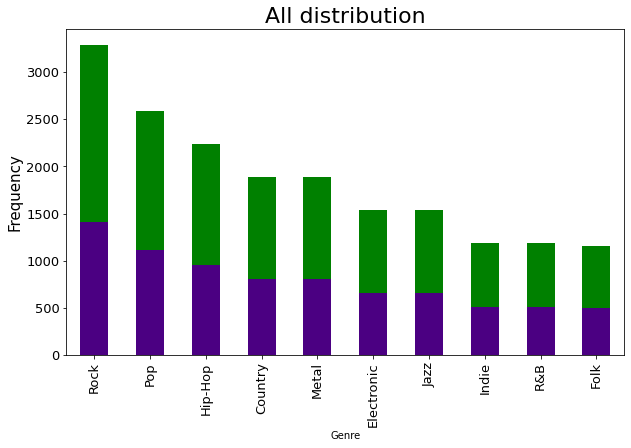

In [3]:
def plot_histogram(df, key, title, color):
    df = df.groupby(by=[key]).count().sort_values("Lyrics", ascending=False)["Lyrics"]
    ax = df.plot(kind='bar', figsize=(10,6), color=color, fontsize=13)
    ax.set_title(title, fontsize=22)
    ax.set_ylabel("Frequency", fontsize=15)
 
plot_histogram(df=train_df, key="Genre", title="", color="green")
plot_histogram(df=test_df, key="Genre", title="All distribution", color="indigo")

print("##### Train Genre distribution #####\n")
print(train_df.groupby(by=["Genre"]).count().sort_values("Lyrics", ascending=False))
print("####################################\n")

print("##### Test Genre distribution #####\n")
print(test_df.groupby(by=["Genre"]).count().sort_values("Lyrics", ascending=False))
print("####################################\n")

Convert the string labels into numerical ones

In [4]:
# sort the genre in decreasing order based on their frequency
genre_mappings = train_df.groupby(by=["Genre"]).count().sort_values("Lyrics", ascending=False).reset_index()["Genre"].tolist() # <--- the genres are stored based on their frequency (non-ascending order).
genre_mappings = {genre: idx for idx, genre in enumerate(genre_mappings)}

# convert string label into integers
train_df["label"] = train_df["Genre"].apply(lambda genre: genre_mappings[genre])
test_df["label"] = test_df["Genre"].apply(lambda genre: genre_mappings[genre])

print("#### Detected genres are, as follows: {}".format(genre_mappings))
print("#### There are: {} genres".format(len(genre_mappings)))

#### Detected genres are, as follows: {'Rock': 0, 'Pop': 1, 'Hip-Hop': 2, 'Country': 3, 'Metal': 4, 'Electronic': 5, 'Jazz': 6, 'Indie': 7, 'R&B': 8, 'Folk': 9}
#### There are: 10 genres


Sanitization function

In [5]:
def sanitize(text, stem_flag=False, remove_stopwords=False):
    text = text.lower() # <---- make to lowercase
    lines = [line for line in text.split("\n") if len(line) > 0] # <---- split by lines

    for i in range(len(lines)):
        current_line = lines[i]
        current_line = re.sub("[{}]+".format(string.punctuation + string.whitespace), " ", current_line) # <--- remove punctuation and other non-relevenat symbols
        words = [word for word in current_line.split(" ") if len(word) > 0]
        
        # Apply a stemmer to the words
        if stem_flag:
            words = [STEMMER.stem(word) for word in words]
        # Remove stopwords
        if remove_stopwords:
            words = [word for word in words if word not in ENGLISH_STOPWORDS] # <--- remove stop_words
        lines[i] = " ".join(words)
    return ". ".join(lines)

Get top 25 words per genre to better understand the data. An immediate observation is that are lots of words (e.g. love, know, like) that overlapps between different genres, which should imply that the task is a hard one. 

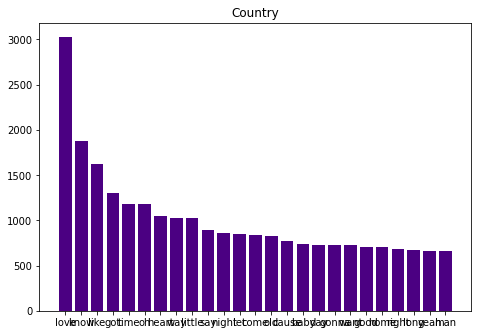

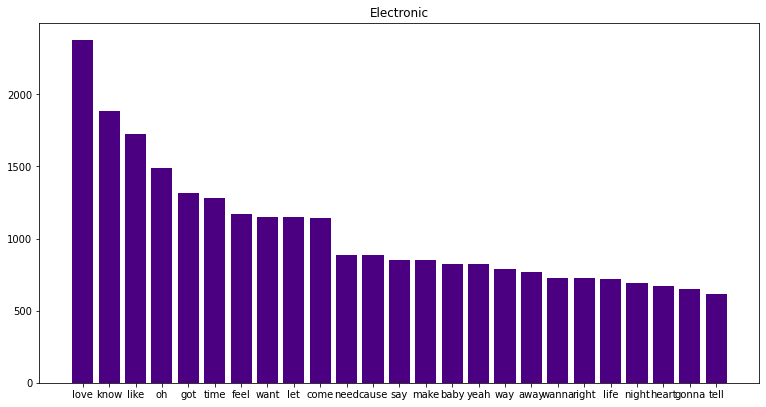

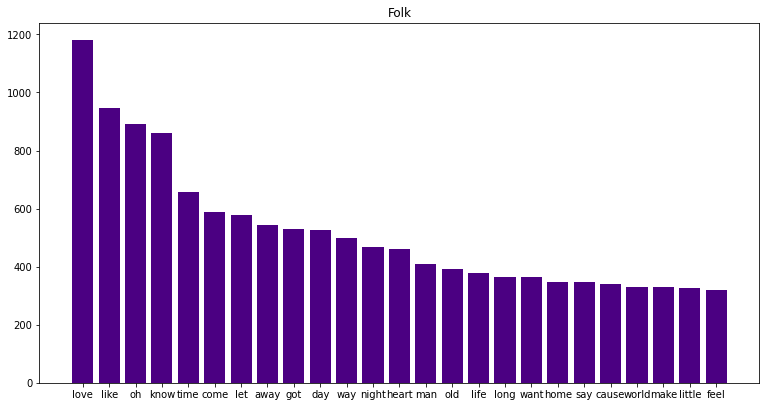

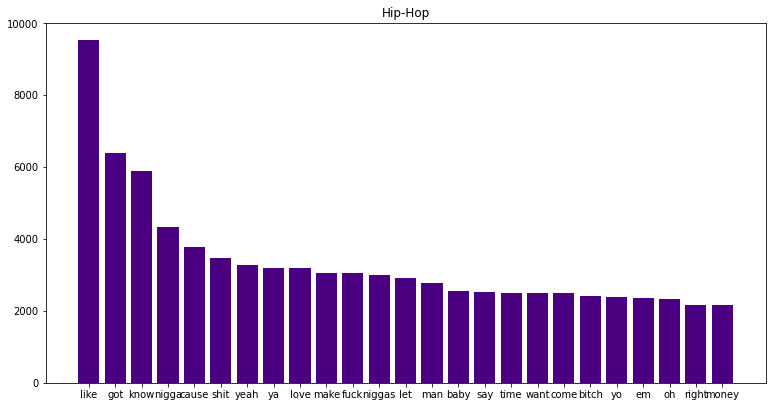

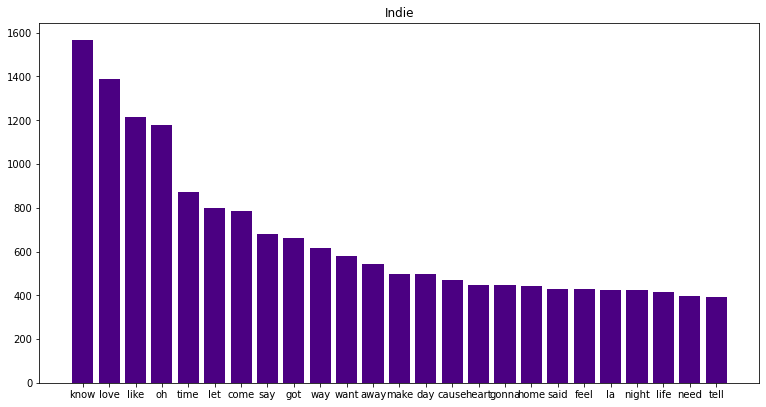

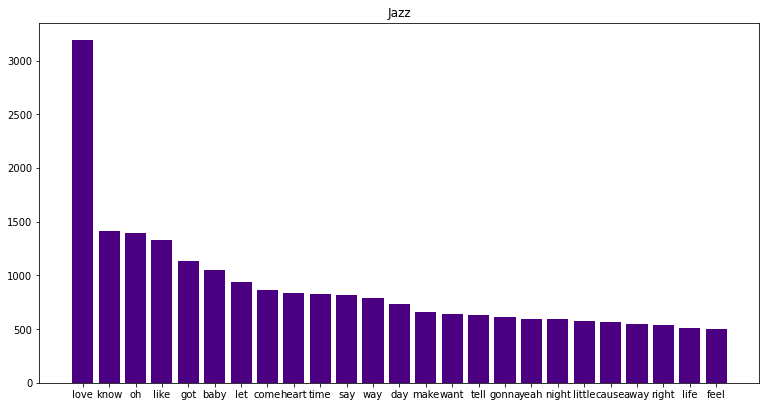

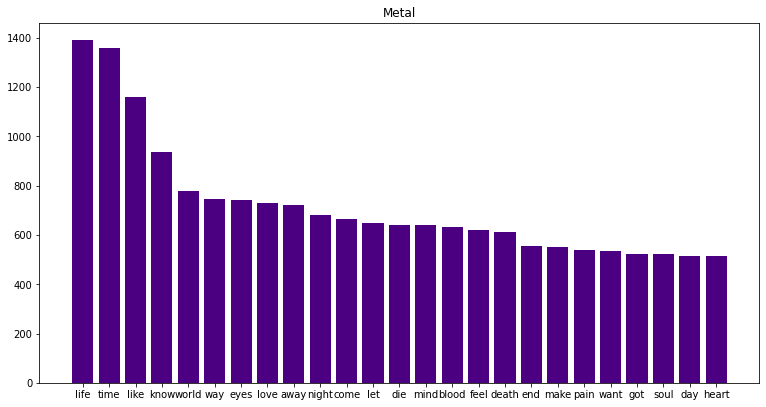

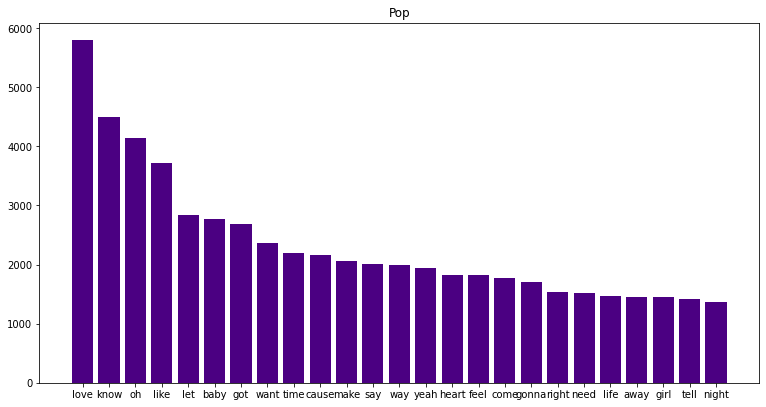

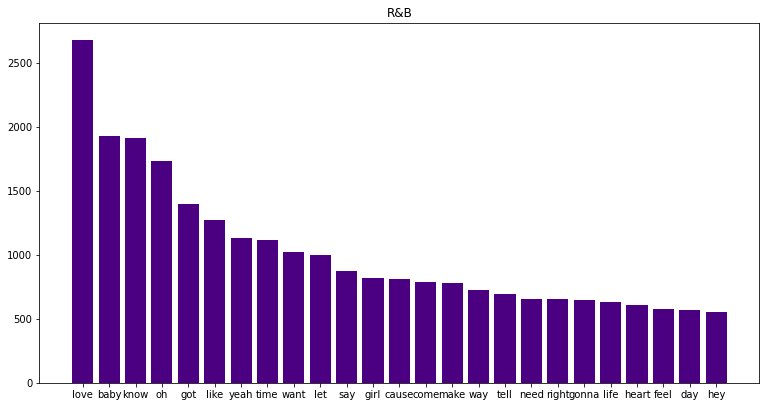

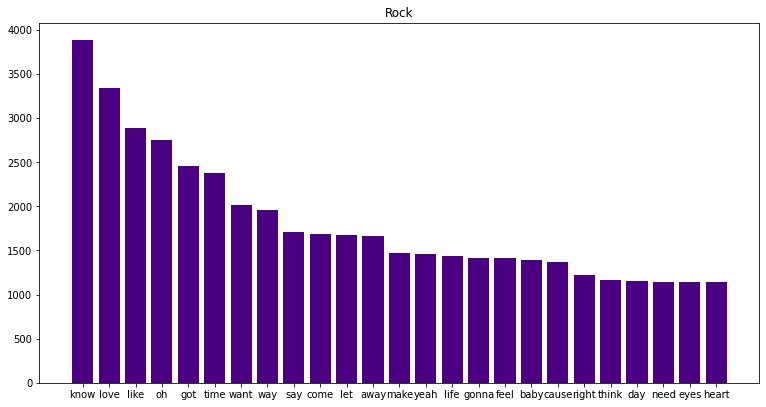

In [6]:
# function that prints top words based on their frequency
def get_top_n_words(texts, title, top_words=20):
    vectorizer = CountVectorizer(stop_words='english')
    bag_of_words = vectorizer.fit_transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_frequency = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
    top_words = words_frequency[:top_words]
    
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10, 5)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar([x[0] for x in top_words], [x[1] for x in top_words], color="indigo")
    ax.set_title(title)
    plt.show()

# for each genre, select top 25 words
grouped_by = train_df.groupby(by="Genre")
for genre in grouped_by.groups.keys():
    sanitized_lyrics = grouped_by.get_group(genre)["Lyrics"].apply(lambda text: sanitize(text, False, True))
    get_top_n_words(sanitized_lyrics, top_words=25, title=genre)

Utils for generating Musical Features (rhyme, rhythm)

Musical Features
*   Average / Standard deviation / Minimum / Maximum / Percentiles 25-50-75 for the number of words per lines.
*   Average / Standard deviation / Minimum / Maximum / Percentiles 25-50-75  for the number of syllables per lines.
*   Average / Standard deviation / Minimum / Maximum / Percentiles 25-50-75 for the number of letters per line.
*   Average / Standard deviation / Minimum / Maximum / Percentiles 25-50-75 for the number of rhymes per blocks (of length 8).
*   The number of rhymes + the number of rhymes normalized (taking into account all possible combinations of rhymes across all the poems).

Semantical features
*   The number of stopwords + the number of stopwords normalized (taking into account the total number of words).
*   The frequency of various part of speeches, as per NLTK (e.g. verb, adjective, noun).

General metrics
*   The number of lines the poem has.
*   The number of words the poem has.
*   The number of letters the poem has.

Readability, Complexity, and Grade level
* Flesch Reading Ease.
* Flesch Kincaid Grade.
* Smog Index.
* Coleman Liau Index.
* Automated Readability Index.
* Dale Chall Readability Score.
* Difficult Words.
* Linsear Write Formula.
* Gunning Fog.
* Fernandez Huerta.
* Szigriszt Pazos.
* Gutierrez Polini.
* Crawford.
* Gulpease Index.
* Osman.


In [7]:
# function that returns whether 2 words rhyme.
def rhymes(word1, word2):
    # if the last two letters are the same => they rhyme
    if word1[-2:] == word2[-2:]:
        return True

    # compute the last possible sounds of the two words
    last_sounds_word1 = [sound.split()[-1] for sound in pronouncing.phones_for_word(word1)]
    last_sounds_word2 = [sound.split()[-1] for sound in pronouncing.phones_for_word(word2)]

    # if there are two overlapping sounds => they rhyme
    for sound1 in last_sounds_word1:
        for sound2 in last_sounds_word2:
            if sound1 == sound2:
                return True

    # get the last syllables for each word
    last_syllable_word1 = SYLLABLES_SPLITTER.inserted(word1).split("-")[-1]
    last_syllable_word2 = SYLLABLES_SPLITTER.inserted(word2).split("-")[-1]

    # if the last syllables are the same => they rhyme
    return last_syllable_word1 == last_syllable_word2

# Compute number of rhymes, based on a list of last words (last word for each verse)
def get_no_rhymes(last_words):
    if len(last_words) <= 1:
        return 0, 0

    # Compute the number of rhymes
    no_rhymes, n = 0, len(last_words)
    for i in range(n):
        for j in range(i + 1, n):
            if rhymes(last_words[i], last_words[j]):
                no_rhymes += 1
    
    # Compute the normalized number of rhymes. There are n * (n - 1) // 2 possible rhymes
    no_rhymes_normalized = no_rhymes * 2.0 / (n * (n - 1))
    return no_rhymes, no_rhymes_normalized

# Compute the frequency of multiple part of speech, as per NLTK. (e.g. N correspond to noun, V to verb)
def compute_part_of_speech_frequency(text):
    words = word_tokenize(text.lower())
    pos_tags = nltk.pos_tag(words)

    freq = {"C": 0, "D": 0, "E": 0, "F": 0, "J": 0, "M": 0, "N": 0, "P": 0, "R": 0, "U": 0, "V": 0, "W": 0}
    for (word, tag) in pos_tags:
        tag = tag[0].upper()
        if tag in freq:
            freq[tag] += 1
    return freq

# Compute the number of stopwords + the normalized number of stopwords
def count_stopwords(text):
    words = word_tokenize(text.lower())
    if len(words) == 0:
        return 0, 0
    
    no_stopwords = np.sum([1 for word in words if word in ENGLISH_STOPWORDS])
    no_stopwords_normalized = no_stopwords / len(words)
    return no_stopwords, no_stopwords_normalized 

# Compute avg, std, min, max, percentile-25-50-75 for an array
def compute_general_metrics(array, name):
    musical_features = {}
    musical_features["avg_{}".format(name)] = np.mean(array)
    musical_features["std_{}".format(name)] = np.std(array)
    musical_features["min_{}".format(name)] = np.min(array)
    musical_features["max_{}".format(name)] = np.max(array)
    musical_features["percentile_25_{}".format(name)] = np.percentile(array, 25)
    musical_features["percentile_50_{}".format(name)] = np.percentile(array, 50)
    musical_features["percentile_75_{}".format(name)] = np.percentile(array, 75)
    return musical_features


def compute_musical_features(text, return_type="dict", debug=False):
    start = time.time()

    text = text.lower() # <---- make to lowercase
    lines = [line for line in text.split("\n") if len(line) > 0] # <---- split into lines
    
    syllables_per_lines, words_per_lines = [], []
    no_syllables_per_lines, no_words_per_lines, no_letters_per_lines = [], [], []
    curated_text = []
    for i in range(len(lines)):
        current_line = lines[i]
        current_line = re.sub("[{}]+".format(string.punctuation + string.whitespace), " ", current_line) # <--- replace any continuous subsequence of special characters with a whitespace
        words = [word for word in current_line.split(" ") if len(word) > 0] # <---- split against whitespaces, and remove them
        if len(words) == 0:
            continue

        syllables_per_lines.append([SYLLABLES_SPLITTER.inserted(word).split("-") for word in words])
        words_per_lines.append(words)
        no_syllables_per_lines.append([len(SYLLABLES_SPLITTER.inserted(word).split("-")) for word in words])
        no_words_per_lines.append(len(words))
        no_letters_per_lines.append(np.sum([len(word) for word in words]))
        
        curated_text.append(current_line)
    
    curated_text = ". ".join(curated_text)

    musical_features = {}
    # Words per lines
    musical_features.update(compute_general_metrics(no_words_per_lines, "words_per_lines"))

    # Syllables per lines
    syllables_frequency = [np.sum(no_syllables_per_line) for no_syllables_per_line in no_syllables_per_lines]
    musical_features.update(compute_general_metrics(syllables_frequency, "syllables_per_lines"))
    
    # Letters per lines
    musical_features.update(compute_general_metrics(no_letters_per_lines, "letters_per_lines"))

    # readability, complexity, and grade level
    musical_features["flesch_reading_ease"] = textstat.flesch_reading_ease(curated_text)
    musical_features["flesch_kincaid_grade"] = textstat.flesch_kincaid_grade(curated_text)
    musical_features["smog_index"] = textstat.smog_index(curated_text)
    musical_features["coleman_liau_index"] = textstat.coleman_liau_index(curated_text)
    musical_features["automated_readability_index"] = textstat.automated_readability_index(curated_text)
    musical_features["dale_chall_readability_score"] = textstat.dale_chall_readability_score(curated_text)
    musical_features["difficult_words"] = textstat.difficult_words(curated_text)
    musical_features["linsear_write_formula"] = textstat.linsear_write_formula(curated_text)
    musical_features["gunning_fog"] = textstat.gunning_fog(curated_text)
    musical_features["fernandez_huerta"] = textstat.fernandez_huerta(curated_text)
    musical_features["szigriszt_pazos"] = textstat.szigriszt_pazos(curated_text)
    musical_features["gutierrez_polini"] = textstat.gutierrez_polini(curated_text)
    musical_features["crawford"] = textstat.crawford(curated_text)
    musical_features["gulpease_index"] = textstat.gulpease_index(curated_text)
    musical_features["osman"] = textstat.osman(curated_text)

    # Compute number of rhymes
    last_words = [words_per_line[-1] for words_per_line in words_per_lines]
    musical_features["rhymes_count"], musical_features["rhymes_count_normalized"] = get_no_rhymes(last_words)
    rhymes_stats = [get_no_rhymes(chunk) for chunk in chunked(last_words, 8)] # <--- split the last words into chunks of 8 and compute the rhyme scores
    musical_features.update(compute_general_metrics([x[0] for x in rhymes_stats], "rhymes_per_block"))

    # compute POS frequencies
    musical_features.update(compute_part_of_speech_frequency(text))

    # compute number of stopwords
    musical_features["count_stopwords"], musical_features["count_stopwords_normalized"] = count_stopwords(text)

    # Overall musical
    musical_features["number_of_words"] = np.sum(no_words_per_lines)
    musical_features["number_of_letters"] = np.sum(no_letters_per_lines)
    musical_features["number_of_lines"] = len(no_words_per_lines)

    # Convert musical to numpy (sorting the keys())
    if return_type in ("npy", "numpy"):
        musical_features = [musical_features[key] for key in sorted(musical_features)]
    end = time.time()

    if debug:
        print("#### Elapsed {} seconds".format(end - start))
    
    return musical_features

example = train_df["Lyrics"][0]
print("##############################")
print(example)
print("##############################")
compute_musical_features(example, return_type="dict", debug=True)

##############################
(INTRO)
The following program deals with controversial subjects, and due to it's explicit nature, parental guidence is strongly advised. The theorys, opinions, and beliefs expressed are not the only possible interpretations. The viewer is invited to make a judgement based on all alvailable information.
Most people agree that evil exsists in this world, for some it's war, famine, or violence. For some it's a spiratual ____?___, and for other's, evil is a very real presence, a physical entity, of terrifying power.
What is evil? Is it mearly a dictionary definition for wrong or bad, or is it something more, a deeper, darker force that makes people perform cruel or inhuman acts. Does an evil force really exsist that can attract and then control the actions of human beings, or is evil nothing more than a convenient excuse for deviant and destructive behavior. These are questions without easy answer's and are continually debated by those who study the human min

{'C': 15,
 'D': 21,
 'E': 0,
 'F': 1,
 'J': 28,
 'M': 1,
 'N': 44,
 'P': 7,
 'R': 8,
 'U': 1,
 'V': 29,
 'W': 3,
 'automated_readability_index': 87.3,
 'avg_letters_per_lines': 162.4,
 'avg_rhymes_per_block': 0.0,
 'avg_syllables_per_lines': 50.8,
 'avg_words_per_lines': 34.6,
 'coleman_liau_index': 11.11,
 'count_stopwords': 78,
 'count_stopwords_normalized': 0.38235294117647056,
 'crawford': 4.3,
 'dale_chall_readability_score': 17.51,
 'difficult_words': 46,
 'fernandez_huerta': -65.7,
 'flesch_kincaid_grade': 70.8,
 'flesch_reading_ease': -104.13,
 'gulpease_index': 43.566473988439306,
 'gunning_fog': 74.06,
 'gutierrez_polini': -10.89,
 'linsear_write_formula': 66.0,
 'max_letters_per_lines': 384,
 'max_rhymes_per_block': 0,
 'max_syllables_per_lines': 118,
 'max_words_per_lines': 83,
 'min_letters_per_lines': 5,
 'min_rhymes_per_block': 0,
 'min_syllables_per_lines': 2,
 'min_words_per_lines': 1,
 'number_of_letters': 812,
 'number_of_lines': 5,
 'number_of_words': 173,
 'osman':

Helper to compute PCA dimensionality reduction (for vizualization purposes). This will help with better understand if the data is separable or not.

In [8]:
def apply_pca_vizualization(X, y):
    print("#### Vizualization using PCA (with scaler) #####")
    labels = [k for k, v in sorted(genre_mappings.items(), key=lambda item: item[1])]
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])
    X_transformed = pipe.fit_transform(X)
    plot = plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
    plt.legend(handles=plot.legend_elements()[0], labels=labels)
    plt.show()
    print("–––––––––––––––––––––––––––––––––––––––––––––––––")

In [9]:
# Cache path to compute and store the features and the labels for different methods
PATH_TO_CACHE = "/content/drive/MyDrive/IRTM-2"

Extract the raw data + labels from the dataframes.

In [10]:
# Extract raw data from train and test sets. Add them to the caching location
def extract_raw_data(train_df, test_df):
    raw_data_filename = "raw_data.npz"
    if os.path.isfile(os.path.join(PATH_TO_CACHE, raw_data_filename)):
        with open(os.path.join(PATH_TO_CACHE, raw_data_filename), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_labels = d["train_labels"]
            test_labels = d["test_labels"]
            train_lyrics = d["train_lyrics"]
            test_lyrics = d["test_lyrics"]
    else:
        train_labels, test_labels = np.asarray(train_df["label"]), np.asarray(test_df["label"])
        train_lyrics, test_lyrics = np.asarray(train_df["Lyrics"]), np.asarray(test_df["Lyrics"])
        with open(os.path.join(PATH_TO_CACHE, raw_data_filename), 'wb') as f:
            np.savez(f, train_labels=train_labels, test_labels=test_labels, train_lyrics=train_lyrics, test_lyrics=test_lyrics)

    return train_lyrics, train_labels, test_lyrics, test_labels

train_lyrics, train_labels, test_lyrics, test_labels = extract_raw_data(train_df, test_df)
print("#### Train lyrics shape: {},  Train labels shape: {}".format(train_lyrics.shape, train_labels.shape))
print("#### Test lyrics shape: {},  Test labels shape: {}".format(test_lyrics.shape, test_labels.shape))


#### Train lyrics shape: (18513,),  Train labels shape: (18513,)
#### Test lyrics shape: (7935,),  Test labels shape: (7935,)


### *Create Musical Features (with caching capability)*

For this types of features, we can easily see that the data overlapps too much and that there is no exact separability between classes (at least not converting them into a 2-dimension representation).

#### Train musical features shape: (18513, 62)
#### Test musical features shape: (7935, 62)
#### Vizualization using PCA (with scaler) #####


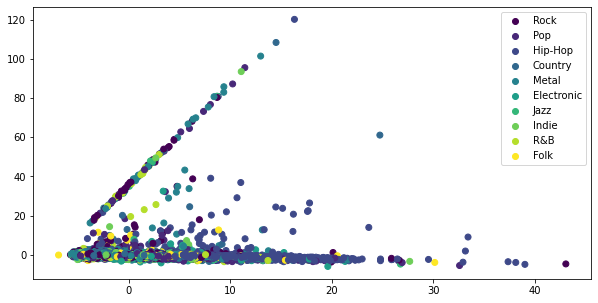

–––––––––––––––––––––––––––––––––––––––––––––––––


In [11]:
# compute musical features for the train and test sets.
def extract_musical_features(train_lyrics, test_lyrics):
    musical_filename = "extracted_musical_features.npz"
    if os.path.isfile(os.path.join(PATH_TO_CACHE, musical_filename)):
        with open(os.path.join(PATH_TO_CACHE, musical_filename), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_musical_features = d["train"]
            test_musical_features = d["test"]
    else:
        train_musical_features = np.asarray([compute_musical_features(text, return_type="numpy") for text in train_lyrics])
        test_musical_features = np.asarray([compute_musical_features(text, return_type="numpy") for text in test_lyrics])
        with open(os.path.join(PATH_TO_CACHE, musical_filename), 'wb') as f:
            np.savez(f, train=train_musical_features, test=test_musical_features)
    return train_musical_features, test_musical_features

train_musical_features, test_musical_features = extract_musical_features(train_lyrics, test_lyrics)

# Standardize the data
scaler = StandardScaler().fit(train_musical_features)
train_musical_features = scaler.transform(train_musical_features)
test_musical_features = scaler.transform(test_musical_features)
print("#### Train musical features shape: {}".format(train_musical_features.shape))
print("#### Test musical features shape: {}".format(test_musical_features.shape))
# Apply PCA vizualization
apply_pca_vizualization(train_musical_features, train_labels)

### *Create BOW Features (with caching capability)*

Remove stop words, and create tf-idf for words only (we also tested with ngrams in the range (3,5) but the results were not improved by much) and extract the most frequent 1000 words (increasing this to 20k would have generated a better performance by ~1.5%, but we wanted to use these features in conjuction with other types of features, so we imposed a reasonable limit). As for the data vizualization, we can see that the data is a little bit better representated in clusters (although different genres still overlap). For instance, `Electronic` and `Jazz` are almost separated by `Hip-hop` and `Pop`, while `Rock` seems to share features on both clusters.

#### Train tfidf features shape: (18513, 1000)
#### Test tfidf features shape: (7935, 1000)
#### Vizualization using PCA (with scaler) #####


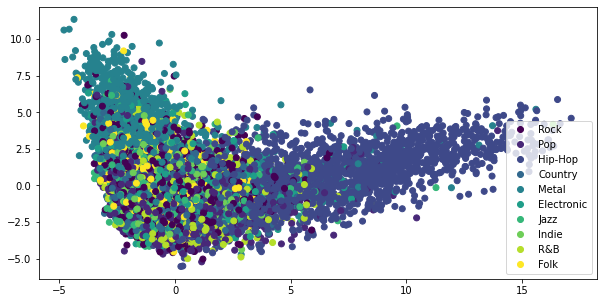

–––––––––––––––––––––––––––––––––––––––––––––––––


In [12]:
def extract_bow_features(train_lyrics, test_lyrics):
    bow_filename = "bow_features.npz"
    STEM_FLAG = True # <--- apply a stemmer to reduce vocabulary size 
    REMOVE_STOPWORDS = True # <--- remove stopwords since they are not representative

    if os.path.isfile(os.path.join(PATH_TO_CACHE, bow_filename)):
        with open(os.path.join(PATH_TO_CACHE, bow_filename), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_tfidf_features = d["train"]
            test_tfidf_features = d["test"]
    else:
        train_sanitized_lyrics = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in train_lyrics]
        test_sanitized_lyrics = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in test_lyrics]
        
        vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=1000, analyzer="word")
        
        train_tfidf_features = vectorizer.fit_transform(train_sanitized_lyrics).toarray()
        test_tfidf_features = vectorizer.transform(test_sanitized_lyrics).toarray()
        with open(os.path.join(PATH_TO_CACHE, bow_filename), 'wb') as f:
            np.savez(f, train=train_tfidf_features, test=test_tfidf_features)

    return train_tfidf_features, test_tfidf_features

train_tfidf_features, test_tfidf_features = extract_bow_features(train_lyrics, test_lyrics)
print("#### Train tfidf features shape: {}".format(train_tfidf_features.shape))
print("#### Test tfidf features shape: {}".format(test_tfidf_features.shape))
apply_pca_vizualization(train_tfidf_features, train_labels)

### *Dense Representation from pre-trained transformer (with caching capability)*

We used `all-MiniLM-L6-v2` petrained model provided by sentence-transformer package to encode text into a 384 dense representation. The data vizualization using this method seem to do a clearly better job in distinguishing among genres than before (although there are still some overlappings since a topic might be used in different genres, although arguably in 'smaller' quantities). 

#### Train dense representation (transformer) features shape: (18513, 384)
#### Test dense representation (transformer) features shape: (7935, 384)
#### Vizualization using PCA (with scaler) #####


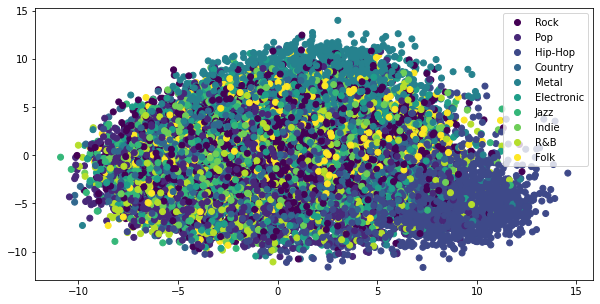

–––––––––––––––––––––––––––––––––––––––––––––––––


In [13]:
def extract_dense_representation(train_lyrics, test_lyrics):
    dense_representation_filename = "dense_representation_features.npz"
    STEM_FLAG = False # <--- dont apply a stemmer
    REMOVE_STOPWORDS = False # <-- dont remove stopwords, as they can provide information when used alongside transformers

    if os.path.isfile(os.path.join(PATH_TO_CACHE, dense_representation_filename )):
        with open(os.path.join(PATH_TO_CACHE, dense_representation_filename ), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_dense_representation_features = d["train"]
            test_dense_representation_features = d["test"]
    else:
        dr_model = SentenceTransformer('all-MiniLM-L6-v2')
        train_sanitized_lyrics = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in train_lyrics]
        test_sanitized_lyrics = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in test_lyrics]

        train_dense_representation_features = np.asarray(dr_model.encode(train_sanitized_lyrics))
        test_dense_representation_features = np.asarray(dr_model.encode(test_sanitized_lyrics))

        with open(os.path.join(PATH_TO_CACHE, dense_representation_filename ), 'wb') as f:
            np.savez(f, train=train_dense_representation_features, test=test_dense_representation_features)
    
    return train_dense_representation_features, test_dense_representation_features

train_dense_representation_features, test_dense_representation_features = extract_dense_representation(train_lyrics, test_lyrics)
print("#### Train dense representation (transformer) features shape: {}".format(train_dense_representation_features.shape))
print("#### Test dense representation (transformer) features shape: {}".format(test_dense_representation_features.shape))
apply_pca_vizualization(train_dense_representation_features, train_labels)

### *Creating sentence embedding using FastText embeddings (with caching capability)*

To generate sentece embeddins, we averaged all the existen word embeddings (given by `FastText`) existent in the lyrics. Stopwords were removed as they usually do not offer much contextual information. The results in data vizualization seem more noisy than before, with lots of overlappings. This was expected, as by averaging we lose a lot of contextual information (relative order of words and how they interact with each other, since the embeddings are static, and not dinamically computed as they were before by using a transformer architecture). Looking at the data, it seems that there is a lot of noise.

#### Train FastText features shape: (18513, 300)
#### Test FastText features shape: (7935, 300)
#### Vizualization using PCA (with scaler) #####


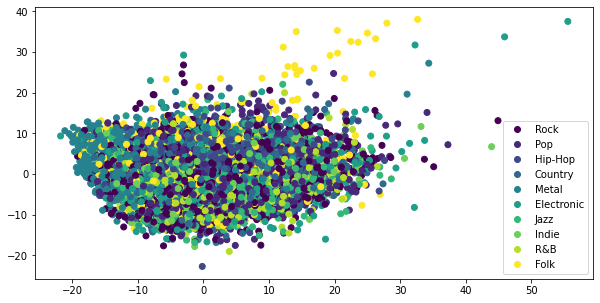

–––––––––––––––––––––––––––––––––––––––––––––––––


In [14]:
def compute_sentence_embedding(fasttext, text):
    text = sanitize(text.lower())
    words = [word for word in text.split() if len(word) > 0]
    embedding_list = []
    for word in words:
        try:
            embedding = fasttext[word] 
            embedding_list.append(embedding)
        except:
            pass
    return np.mean(embedding_list, axis=0)

def extract_fasttext_representation(train_lyrics, test_lyrics):
    fasttext_filename = "fasttext_features.npz"
    STEM_FLAG = False # <--- dont apply a stem (as Fasttext can distinguish small modifications)
    REMOVE_STOPWORDS = True # <--- remove stop words as they dont provide useful information when averaging

    if os.path.isfile(os.path.join(PATH_TO_CACHE, fasttext_filename)):
        with open(os.path.join(PATH_TO_CACHE, fasttext_filename), 'rb') as f:
            d = np.load(f, allow_pickle=True)
            train_fasttext_features = d["train"]
            test_fasttext_features = d["test"]
    else:
        fasttext = gensim.downloader.load('fasttext-wiki-news-subwords-300')
        train_sanitized_lyrics = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in train_lyrics]
        test_sanitized_lyrics = [sanitize(text, stem_flag=STEM_FLAG, remove_stopwords=REMOVE_STOPWORDS) for text in test_lyrics]

        train_fasttext_features = np.asarray([compute_sentence_embedding(fasttext, text) for text in train_sanitized_lyrics])
        test_fasttext_features = np.asarray([compute_sentence_embedding(fasttext, text) for text in test_sanitized_lyrics])
        with open(os.path.join(PATH_TO_CACHE, fasttext_filename), 'wb') as f:
            np.savez(f, train=train_fasttext_features, test=test_fasttext_features)

    return train_fasttext_features, test_fasttext_features

train_fasttext_features, test_fasttext_features = extract_fasttext_representation(train_lyrics, test_lyrics)
print("#### Train FastText features shape: {}".format(train_fasttext_features.shape))
print("#### Test FastText features shape: {}".format(test_fasttext_features.shape))
apply_pca_vizualization(train_fasttext_features, train_labels)

### *Aggregate Multiple Features Types*

 We aggregated `musical`, `BOW`, `dense representation` (not the embeddings from `FastText` though as they are somehow "included" in a way in the representation given by the transformer). The `BOW` features are used to offer an intuition of the most relevant words per poem (the transformer can offer an idea about the `what` the poem is about, but not really about which words were used, which might provide some extra information). They way data look may suggest a technique involving a hierarchical approach in modelling.

#### Train combined features shape: (18513, 1446)
#### Test combined features shape: (7935, 1446)
#### Vizualization using PCA (with scaler) #####


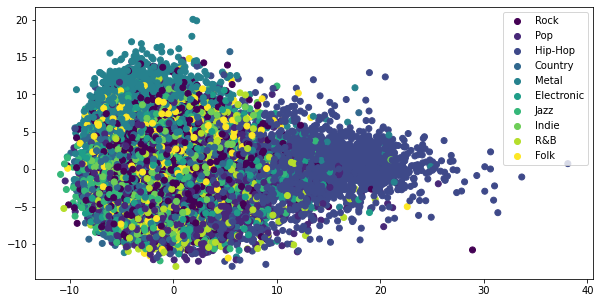

–––––––––––––––––––––––––––––––––––––––––––––––––


In [15]:
train_all_features = np.concatenate((train_musical_features, train_tfidf_features, train_dense_representation_features), axis=1)
test_all_features = np.concatenate((test_musical_features, test_tfidf_features, test_dense_representation_features), axis=1)
print("#### Train combined features shape: {}".format(train_all_features.shape))
print("#### Test combined features shape: {}".format(test_all_features.shape))
apply_pca_vizualization(train_all_features, train_labels)

# **Modelling Utils**

Some useful functions to be used during training and scoring.

In [16]:
PERFORMANCE = {}

# Custom plot chart based on key-values
def plot_barchart_custom(keys, values, title, colors=None, fig_size=(12, 7)):
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = fig_size
    ax = fig.add_axes([0, 0, 1, 1])
    if colors is None:
        colors = ['red', 'green', 'blue', "indigo", "cyan", "black", "m", "y", "c", "tab:brown"]
    
    values = np.asarray(values)
    ax.bar(keys, values, color=colors[:len(keys)])
    ax.set_title(title)
    for i in range(len(keys)):
        plt.text(i, values[i] + 0.5, values[i]) 
    plt.show()

# Perform cross_validation using a set of train (which will be split into train + val internally) + a final test set.
# The model to be used, as well as its parameters are given as parameters to this function.
def train_with_crossvalidation(train_data, train_labels, test_data, test_labels, 
                               name, performance_dict,
                               class_name=None, parameters=None, predict_func=None, no_folds=5, print_confusion_matrix=False):
    assert (class_name is not None) ^ (predict_func is not None)
    if parameters is None:
        parameters = {}

    print("##### Cross validation on {} #####\n".format(name))
    kfold = KFold(n_splits=no_folds)
    accuracy_list = []
    # Split into folds
    for train_indices, validation_indices in kfold.split(train_data):
        # Load the corresponding data
        X_train, X_validation = train_data[train_indices], train_data[validation_indices]
        y_train, y_validation = train_labels[train_indices], train_labels[validation_indices]
        X_test, y_test = test_data, test_labels
        
        # Instantiate the class with the passed parameters
        if class_name is not None:  
            model = class_name(**parameters)
            try:
                model.fit(X_train, y_train, verbose=False)
            except:
                model.fit(X_train, y_train)
            # pass the predict function
            predict_func = model.predict

        train_predicted = predict_func(X_train)
        validation_predicted = predict_func(X_validation)
        test_predicted = predict_func(X_test)

        accuracy_train = accuracy_score(y_train, train_predicted)
        accuracy_validation = accuracy_score(y_validation, validation_predicted)
        accuracy_test = accuracy_score(y_test, test_predicted)
        
        print("###################\n")
        print("#### [Train] Accuracy: {}%".format(accuracy_train * 100.0))
        print("#### [Validation] Accuracy: {}%".format(accuracy_validation * 100.0))
        print("#### [Test] Accuracy: {}%".format(accuracy_test * 100.0))
        print("###################\n")
        accuracy_list.append(accuracy_test * 100)
    performance_dict[name] = round(np.mean(accuracy_list), 2)

    # Print the confusion matrix
    if print_confusion_matrix:
        labels = [k for k, v in sorted(genre_mappings.items(), key=lambda item: item[1])]
        cm = confusion_matrix(y_test, test_predicted, normalize="all")
        cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title("#### Confusion Matrix Normalized for {} ####\n".format(name))
        cmp.plot(ax=ax)
    
    print("-----------------------------------------\n")
    return accuracy_list

In [17]:
# Function used to perform training on multiple models and recording the result from the cross-validation.
def perform_exhaustive_training(train_data, train_labels, test_data, test_labels, features_type, no_folds=5, print_confusion_matrix=False):
    performance = {}
    class_weights = None
    
    ### SVM ###
    parameters_svm = {"class_weight": class_weights}
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=SVC,
                               parameters=parameters_svm,
                               no_folds=no_folds,
                               name="SVM_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)
    ### CatBoost ###
    parameters_catboost = {"iterations": 1000,
                           "task_type": "GPU",
                           "devices": '0',
                           "auto_class_weights": class_weights
                           }
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=CatBoostClassifier,
                               parameters=parameters_catboost,
                               no_folds=no_folds,
                               name="CatBoost_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)
    ### LogisticRegression ###
    parameters_logistic_regression = {"max_iter": 1000, "class_weight": class_weights}
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=LogisticRegression,
                               parameters=parameters_logistic_regression,
                               no_folds=no_folds,
                               name="LogisticRegression_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)
    ### RandomForest ###
    parameters_randomforest = {"class_weight": class_weights}
    train_with_crossvalidation(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels,
                               class_name=RandomForestClassifier,
                               parameters=parameters_randomforest,
                               no_folds=no_folds,
                               name="RandomForest_{}_features".format(features_type), performance_dict=performance,
                               print_confusion_matrix=print_confusion_matrix)

    # Plot the performance of the these models
    performance = {k: v for k, v in sorted(performance.items(), key=lambda item: item[1])}
    keys = [key.split("_")[0] for key in performance.keys()]
    values = list(performance.values())
    plot_barchart_custom(keys, values, title="Feature Type: {}".format(features_type))

    return performance


# **Random models**

## *Pure Random (almost 10% as there are 10 classes)*

In [18]:
_ = train_with_crossvalidation(train_data=train_lyrics, train_labels=train_labels, test_data=test_lyrics, test_labels=test_labels,
                               predict_func=lambda features: [random.randint(0, len(genre_mappings) - 1) for _ in range(len(features))],
                               no_folds=5, name="pure_random", performance_dict=PERFORMANCE, print_confusion_matrix=False)

##### Cross validation on pure_random #####

###################

#### [Train] Accuracy: 9.9932478055368%
#### [Validation] Accuracy: 10.045908722657305%
#### [Test] Accuracy: 10.044108380592313%
###################

###################

#### [Train] Accuracy: 9.939230249831194%
#### [Validation] Accuracy: 9.127734269511208%
#### [Test] Accuracy: 9.439193446754883%
###################

###################

#### [Train] Accuracy: 9.797434166103985%
#### [Validation] Accuracy: 10.532001080205239%
#### [Test] Accuracy: 10.308758664146188%
###################

###################

#### [Train] Accuracy: 9.898048747552494%
#### [Validation] Accuracy: 10.021609940572663%
#### [Test] Accuracy: 10.296156269691242%
###################

###################

#### [Train] Accuracy: 10.01958004186078%
#### [Validation] Accuracy: 10.507833603457591%
#### [Test] Accuracy: 10.535601764335224%
###################

-----------------------------------------



## *Weighted Random*

Randomly sample a label, but each genre has a weight associated with it (more frequent genre will be sampled more).

In [19]:
def predict_weighted_random(features, frequency_dict):
    population = list(frequency_dict.keys())
    weights = list(frequency_dict.values())
    total = np.sum(weights)
    weights = [x / total for x in weights]

    return random.choices(population=population, weights=weights, k=len(features))

_ = train_with_crossvalidation(train_data=train_lyrics, train_labels=train_labels, test_data=test_lyrics, test_labels=test_labels,
                               predict_func=lambda features: predict_weighted_random(features, frequency_dict=Counter(train_labels)),
                               no_folds=5, name="weighted_random", performance_dict=PERFORMANCE, print_confusion_matrix=False)

##### Cross validation on weighted_random #####

###################

#### [Train] Accuracy: 10.803511141120865%
#### [Validation] Accuracy: 12.746421820145828%
#### [Test] Accuracy: 11.43037177063642%
###################

###################

#### [Train] Accuracy: 11.478730587440918%
#### [Validation] Accuracy: 11.396165271401566%
#### [Test] Accuracy: 11.165721487082546%
###################

###################

#### [Train] Accuracy: 11.36394328156651%
#### [Validation] Accuracy: 12.098298676748582%
#### [Test] Accuracy: 10.611216131064902%
###################

###################

#### [Train] Accuracy: 11.275403416379717%
#### [Validation] Accuracy: 11.183144246353322%
#### [Test] Accuracy: 10.560806553245117%
###################

###################

#### [Train] Accuracy: 11.045844304908513%
#### [Validation] Accuracy: 10.8860075634792%
#### [Test] Accuracy: 11.178323881537493%
###################

-----------------------------------------



## *Predicting the most frequent class*

In [20]:
def predict_most_commom(features, frequency_dict):
    most_frequent_key = [key for key in frequency_dict if frequency_dict[key] == max(frequency_dict.values())][0]
    return [most_frequent_key] * len(features) 

_ = train_with_crossvalidation(train_data=train_lyrics, train_labels=train_labels, test_data=test_lyrics, test_labels=test_labels,
                               predict_func=lambda features: predict_most_commom(features, frequency_dict=Counter(train_labels)),
                               no_folds=5, name="predict_most_common", performance_dict=PERFORMANCE, print_confusion_matrix=False)

##### Cross validation on predict_most_common #####

###################

#### [Train] Accuracy: 18.048615800135043%
#### [Validation] Accuracy: 16.662165811504188%
#### [Test] Accuracy: 17.76937618147448%
###################

###################

#### [Train] Accuracy: 17.805536799459826%
#### [Validation] Accuracy: 17.634350526600056%
#### [Test] Accuracy: 17.76937618147448%
###################

###################

#### [Train] Accuracy: 17.670492910195815%
#### [Validation] Accuracy: 18.174453146097758%
#### [Test] Accuracy: 17.76937618147448%
###################

###################

#### [Train] Accuracy: 17.541016811829046%
#### [Validation] Accuracy: 18.692598595353864%
#### [Test] Accuracy: 17.76937618147448%
###################

###################

#### [Train] Accuracy: 17.790831139018298%
#### [Validation] Accuracy: 17.693138843868176%
#### [Test] Accuracy: 17.76937618147448%
###################

-----------------------------------------



## *Comparison of non-learner models*

Easily, the method of predicting the most frequent class from the training set achieve better than the random sampling methods. Our baseline model will be better than 17.77% as we will see in the incoming sections! 

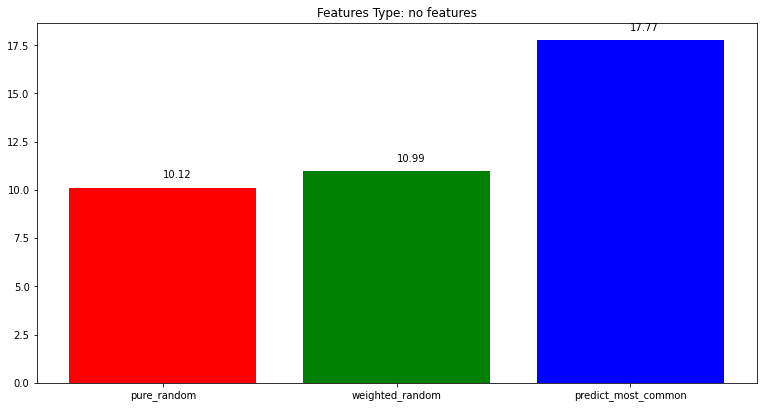

In [21]:
performance = {key: PERFORMANCE[key] for key in PERFORMANCE if "random" in key or "common" in key.lower()}
performance = {k: v for k, v in sorted(performance.items(), key=lambda item: item[1])}

keys = list(performance.keys())
values = list(performance.values())

plot_barchart_custom(keys, values, title="Features Type: no features")

# **Shallow models**

In [23]:
NO_FOLDS = 3
PRINT_CONFUSION_MATRIX = True

## *Using Musical Features*

The results indicate that the performance obtained is at 34.3% (with slight modification in prediction among the four tested models), almost doubles when compared to the previous "method" (predicting the most frequent class). The model architecture seems to not statistically affect performance.

##### Cross validation on SVM_musical_features #####

###################

#### [Train] Accuracy: 37.22249230270621%
#### [Validation] Accuracy: 33.56020093988008%
#### [Test] Accuracy: 33.68620037807183%
###################

###################

#### [Train] Accuracy: 36.549991897585485%
#### [Validation] Accuracy: 34.629719656457624%
#### [Test] Accuracy: 33.24511657214871%
###################

###################

#### [Train] Accuracy: 37.327823691460054%
#### [Validation] Accuracy: 33.835683033543994%
#### [Test] Accuracy: 34.177693761814744%
###################

-----------------------------------------

##### Cross validation on CatBoost_musical_features #####

###################

#### [Train] Accuracy: 89.47496353913466%
#### [Validation] Accuracy: 34.45146653702803%
#### [Test] Accuracy: 34.417139256458725%
###################

###################

#### [Train] Accuracy: 88.70523415977961%
#### [Validation] Accuracy: 35.488575595527465%
#### [Test] Accuracy: 34.21550094517958

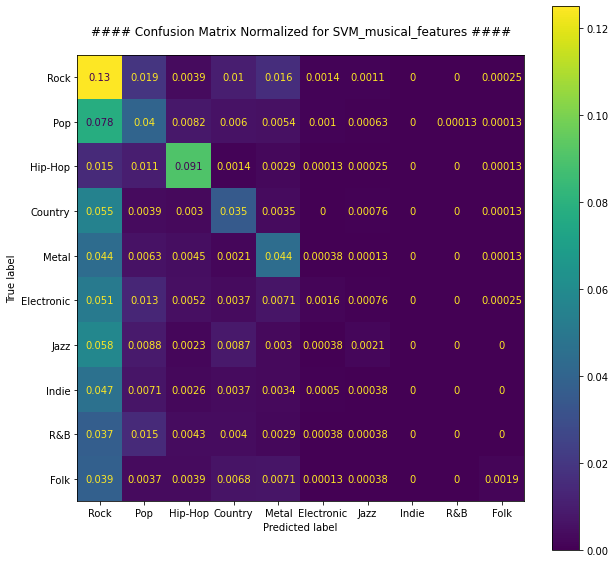

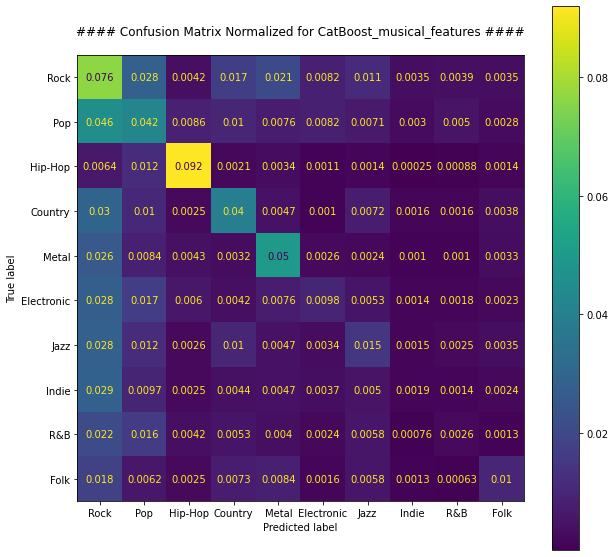

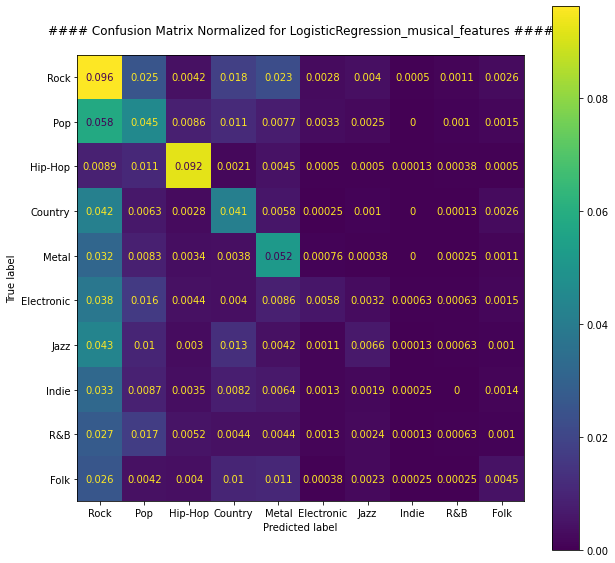

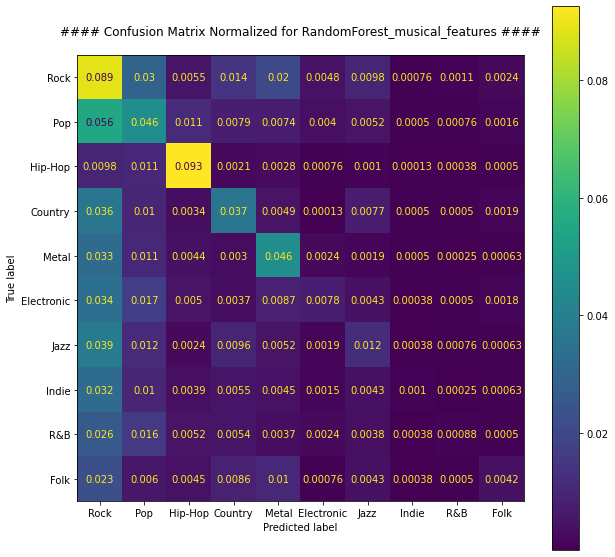

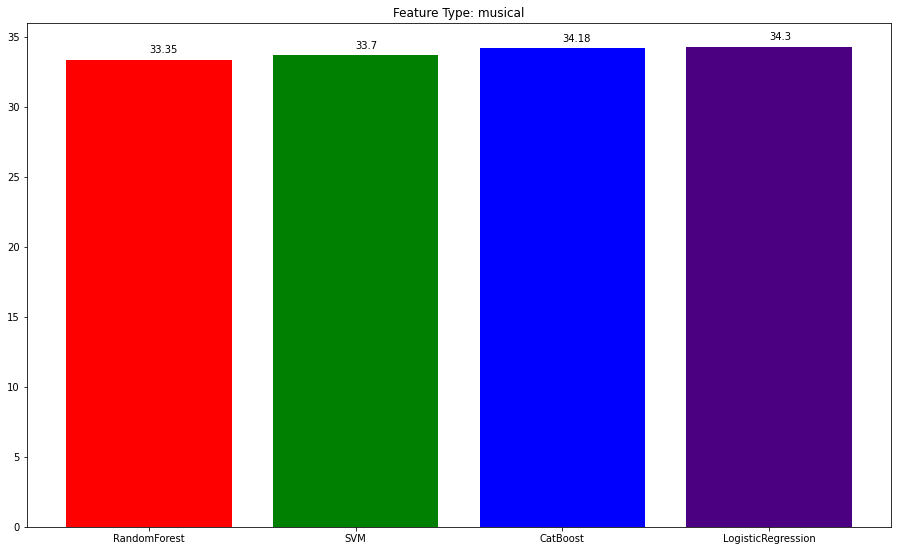

In [ ]:
performance = perform_exhaustive_training(train_data=train_musical_features, train_labels=train_labels, test_data=test_musical_features, test_labels=test_labels, features_type="musical", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *Bag of Words (TF-IDF)*

The models' performance increase from the previous experiment, the best (CatBoost) reaching a staggering 40%. This behaviour suggests that there are some words that are representative for a set of genres collection. We will use this features for aggregation to see if adding contextual features (from transformer) + musical features improves performance.

##### Cross validation on SVM_tfidf_features #####

###################

#### [Train] Accuracy: 77.15119105493436%
#### [Validation] Accuracy: 37.15767298655%
#### [Test] Accuracy: 38.4247006931317%
###################

###################

#### [Train] Accuracy: 77.19980554205154%
#### [Validation] Accuracy: 38.29201101928375%
#### [Test] Accuracy: 37.16446124763705%
###################

###################

#### [Train] Accuracy: 77.87230594717226%
#### [Validation] Accuracy: 38.210986874088476%
#### [Test] Accuracy: 38.0466288594833%
###################

-----------------------------------------

##### Cross validation on CatBoost_tfidf_features #####

###################

#### [Train] Accuracy: 65.24874412574947%
#### [Validation] Accuracy: 39.928698752228165%
#### [Test] Accuracy: 40.15122873345936%
###################

###################

#### [Train] Accuracy: 65.27305136930805%
#### [Validation] Accuracy: 40.41484362339977%
#### [Test] Accuracy: 39.78575929426591%
############

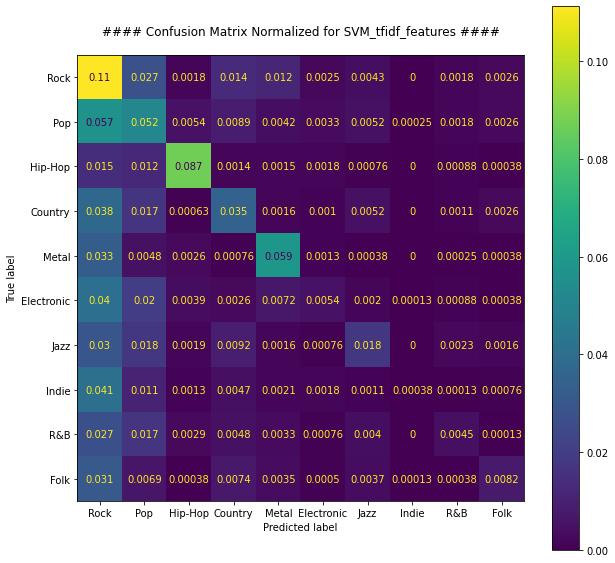

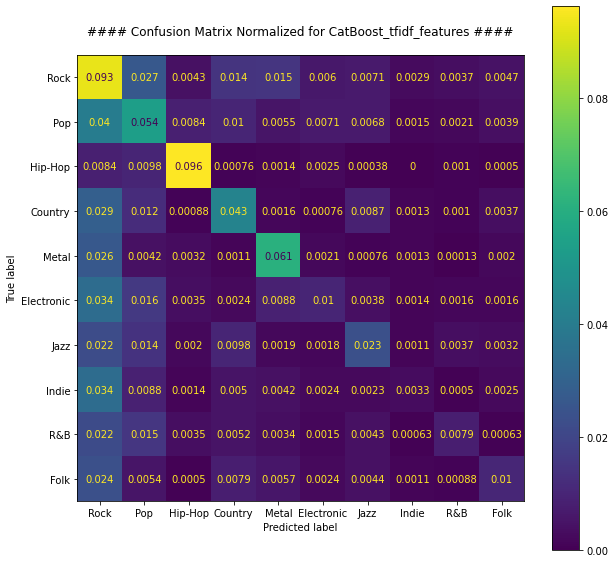

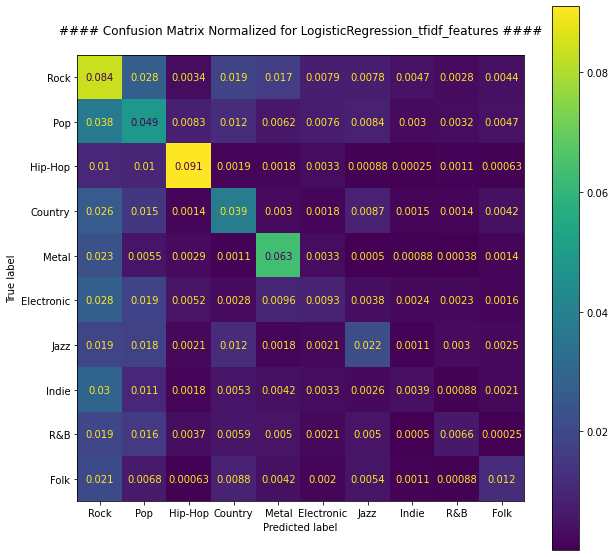

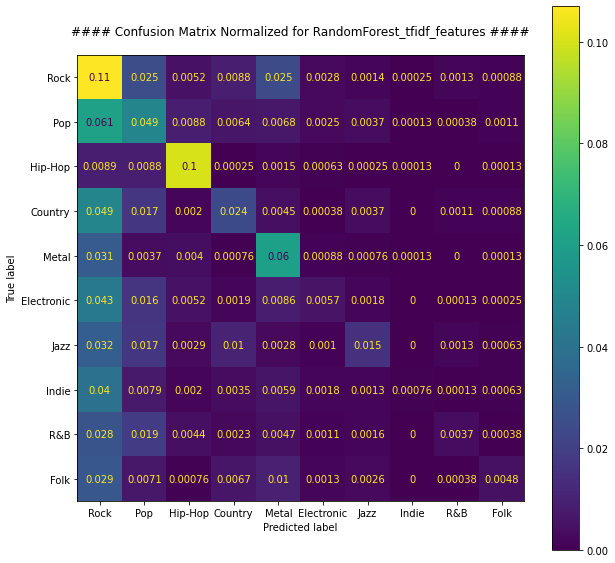

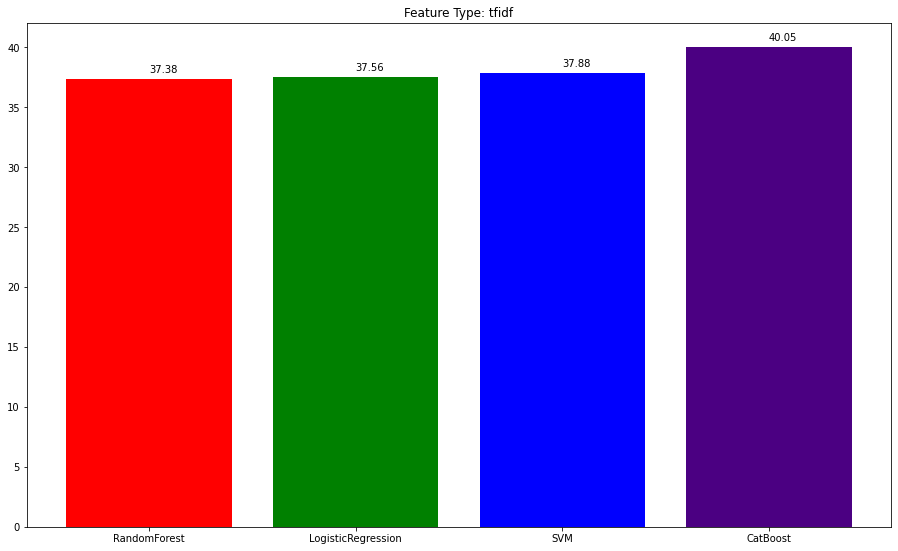

In [ ]:
performance = perform_exhaustive_training(train_data=train_tfidf_features, train_labels=train_labels, test_data=test_tfidf_features, test_labels=test_labels, features_type="tfidf", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *Sentence Embeddings (Dense Representation)*

For this experiment the results are further improving, the best model (SVM) reaching about 42% accuracy, followed closely by LogistRegression and CatBoost. These results alone suggest that the embedding provided by the transformer architecture manage to better capture the meaning of the lyrics and thus, offering better prediction results.

##### Cross validation on SVM_dense_representation_features #####

###################

#### [Train] Accuracy: 60.59795819154108%
#### [Validation] Accuracy: 41.2088802463134%
#### [Test] Accuracy: 42.48267170762445%
###################

###################

#### [Train] Accuracy: 59.34208394101442%
#### [Validation] Accuracy: 42.11635067250041%
#### [Test] Accuracy: 41.77693761814745%
###################

###################

#### [Train] Accuracy: 60.93015718684168%
#### [Validation] Accuracy: 41.646410630367846%
#### [Test] Accuracy: 41.97857592942659%
###################

-----------------------------------------

##### Cross validation on CatBoost_dense_representation_features #####

###################

#### [Train] Accuracy: 99.0034030140982%
#### [Validation] Accuracy: 39.60460217144709%
#### [Test] Accuracy: 40.61751732829237%
###################

###################

#### [Train] Accuracy: 98.91427645438341%
#### [Validation] Accuracy: 40.70653054610274%
#### [Test] Accuracy:

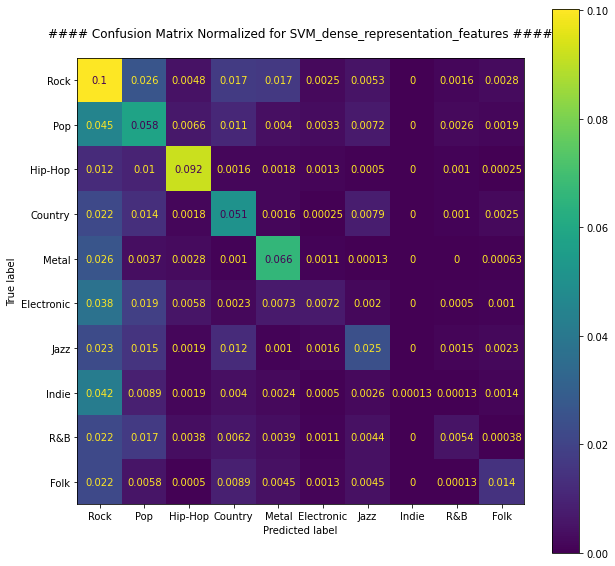

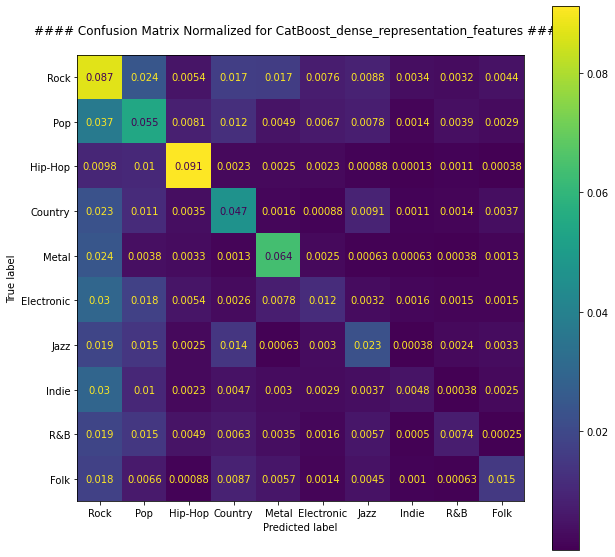

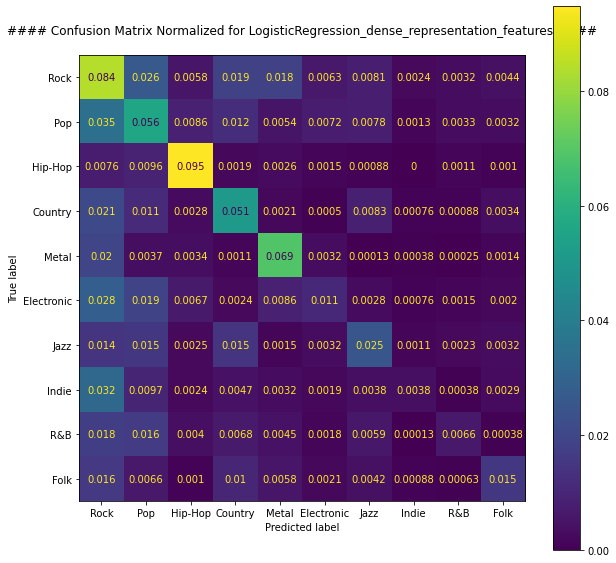

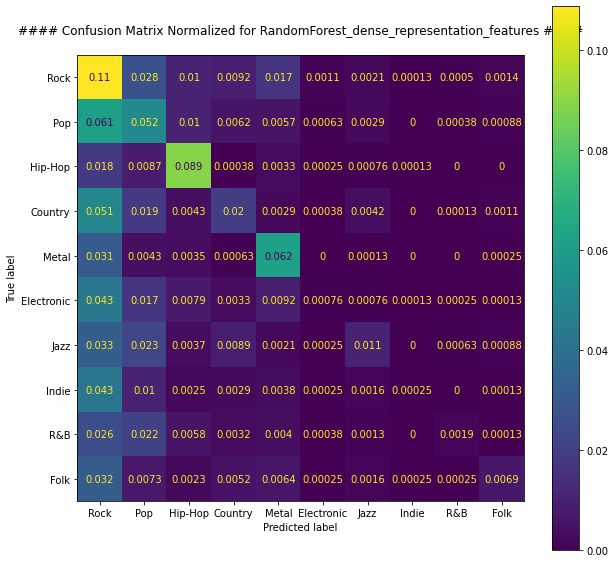

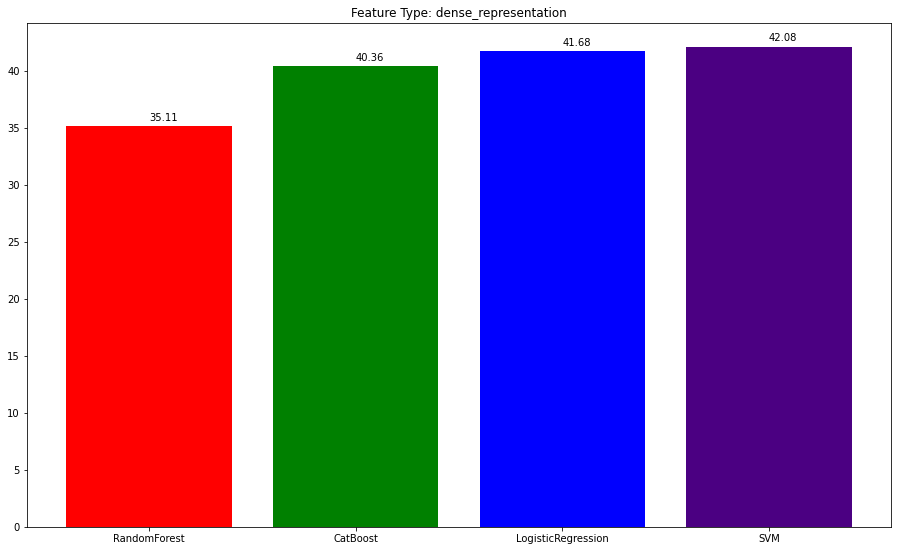

In [ ]:
performance = perform_exhaustive_training(train_data=train_dense_representation_features, train_labels=train_labels, test_data=test_dense_representation_features, test_labels=test_labels, features_type="dense_representation", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *FastText Representation*

The results using as sentence embedding the averaging of each word's embedding (given by `FastText`) offer poorer results (around 38.1%), although the `CatBoost` model did manage to beat the best model trained with musical features. This might suggest that the musical features cannot exhaustively capture all the genres' traits, and so they are not suitable enough to predict only against them. In the next experiment we will try to aggregate features from multiple sources (musical + sentence embedding from transfomer + BOW) and check if this solution improves the end-to-end performance. 

##### Cross validation on SVM_fasttext_features #####

###################

#### [Train] Accuracy: 35.431858693890774%
#### [Validation] Accuracy: 33.949116836817375%
#### [Test] Accuracy: 33.61058601134215%
###################

###################

#### [Train] Accuracy: 34.67023172905526%
#### [Validation] Accuracy: 34.289418246637496%
#### [Test] Accuracy: 33.40894770006301%
###################

###################

#### [Train] Accuracy: 35.61011181332037%
#### [Validation] Accuracy: 33.608815426997246%
#### [Test] Accuracy: 34.12728418399496%
###################

-----------------------------------------

##### Cross validation on CatBoost_fasttext_features #####

###################

#### [Train] Accuracy: 99.38421649651596%
#### [Validation] Accuracy: 37.75725166099498%
#### [Test] Accuracy: 38.651543793320734%
###################

###################

#### [Train] Accuracy: 99.40042132555502%
#### [Validation] Accuracy: 38.69713174526009%
#### [Test] Accuracy: 37.37870195337114

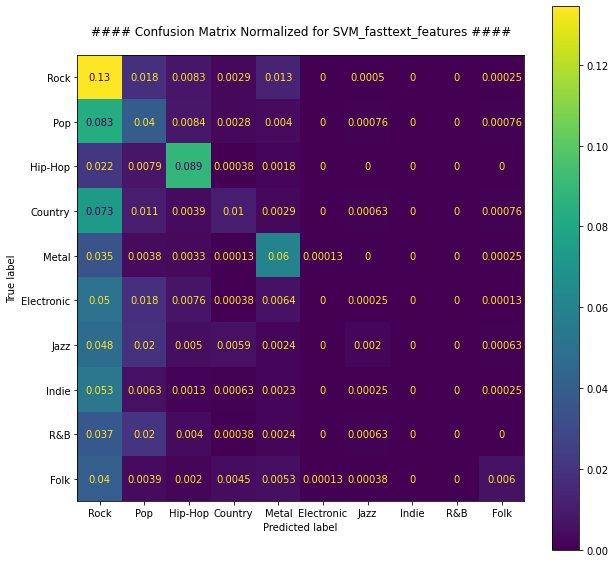

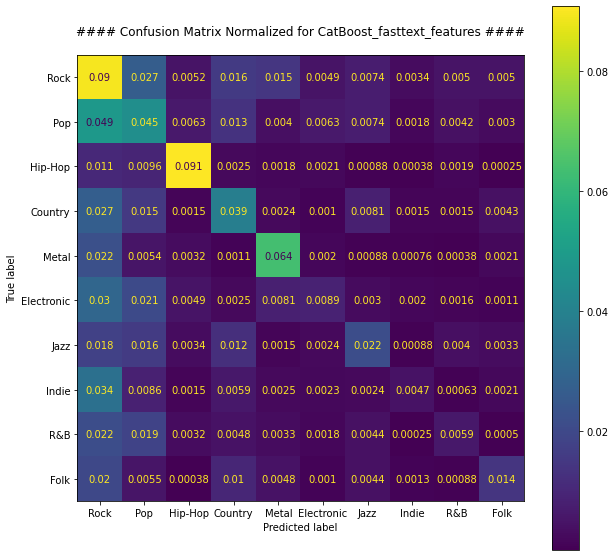

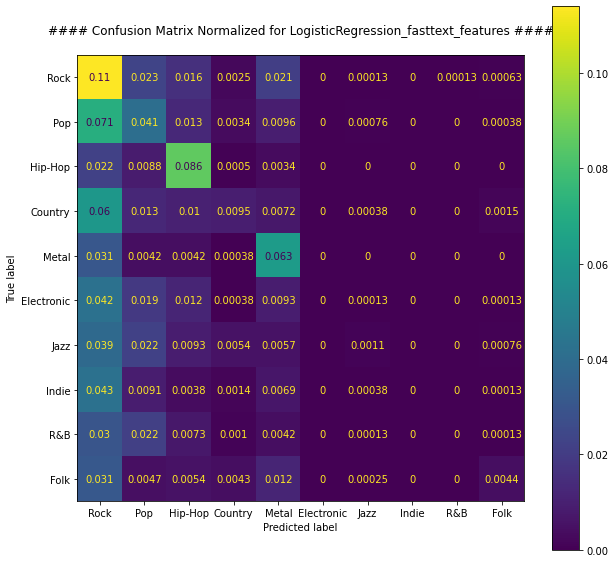

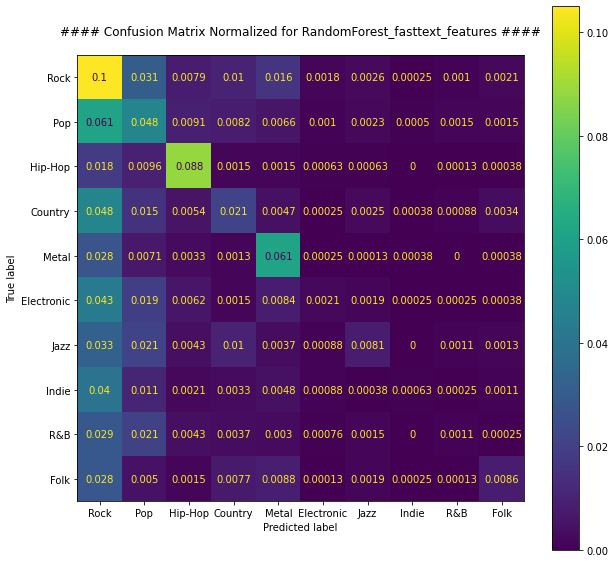

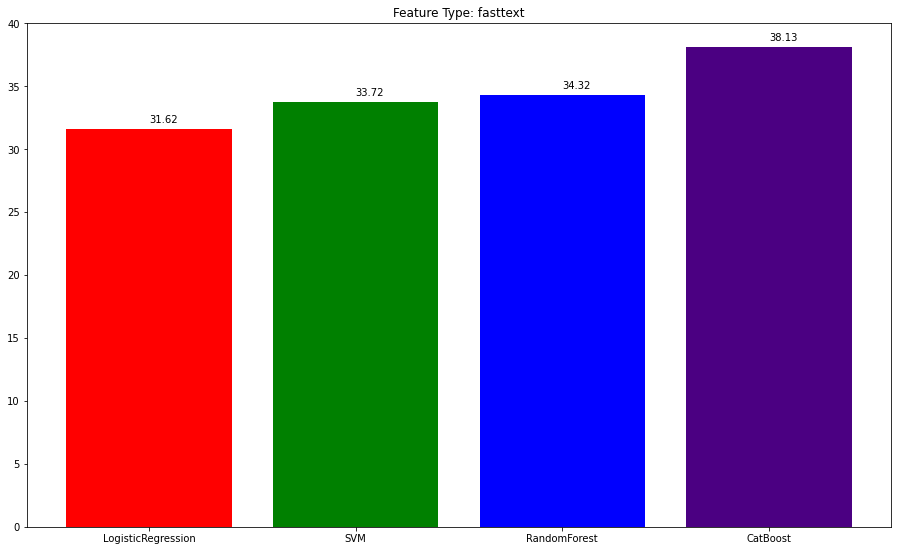

In [24]:
performance = perform_exhaustive_training(train_data=train_fasttext_features, train_labels=train_labels, test_data=test_fasttext_features, test_labels=test_labels, features_type="fasttext", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *All features combined (Musical + Dense Representation + BOW)*

The results exhibited in this section show that aggregating musical, contextual and BOW features indeed increased the end-to-end performance of our models. Both `LogisticRegression` and `CatBoost` reach a staggering 43.5% accuracy performance. The other two models (`SVM` and `RandomForest`) managed to obtained around 38%. Considering that we did not properly tunned the parameters of these models, we can `safely` assume that we could actually increase these numbers by 1-2%, which would provide an astonishing performance. 

##### Cross validation on SVM_all_features #####

###################

#### [Train] Accuracy: 42.43234483876195%
#### [Validation] Accuracy: 37.59520337060444%
#### [Test] Accuracy: 37.870195337114055%
###################

###################

#### [Train] Accuracy: 41.865175822395074%
#### [Validation] Accuracy: 38.40544482255712%
#### [Test] Accuracy: 37.013232514177695%
###################

###################

#### [Train] Accuracy: 42.75644141954302%
#### [Validation] Accuracy: 38.146167557932266%
#### [Test] Accuracy: 38.008821676118465%
###################

-----------------------------------------

##### Cross validation on CatBoost_all_features #####

###################

#### [Train] Accuracy: 84.01393615297359%
#### [Validation] Accuracy: 43.99611084103063%
#### [Test] Accuracy: 43.54127284183995%
###################

###################

#### [Train] Accuracy: 84.10306271268838%
#### [Validation] Accuracy: 43.70442391832766%
#### [Test] Accuracy: 43.2010081915564%
#########

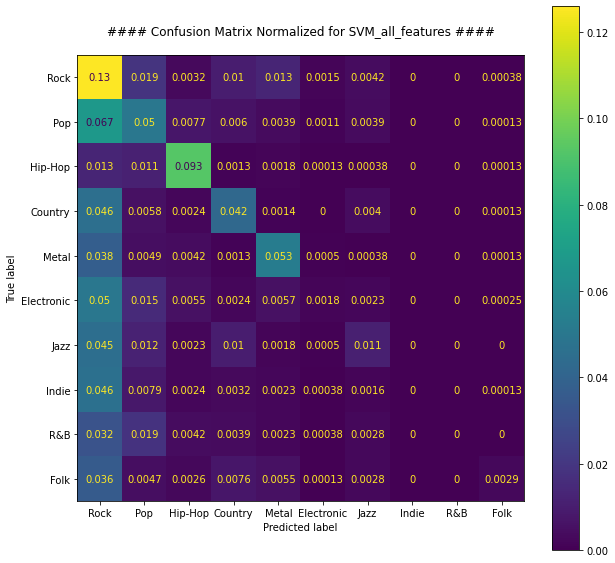

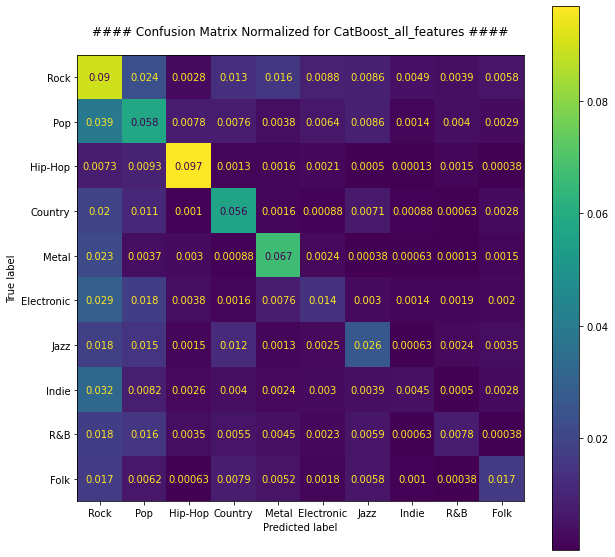

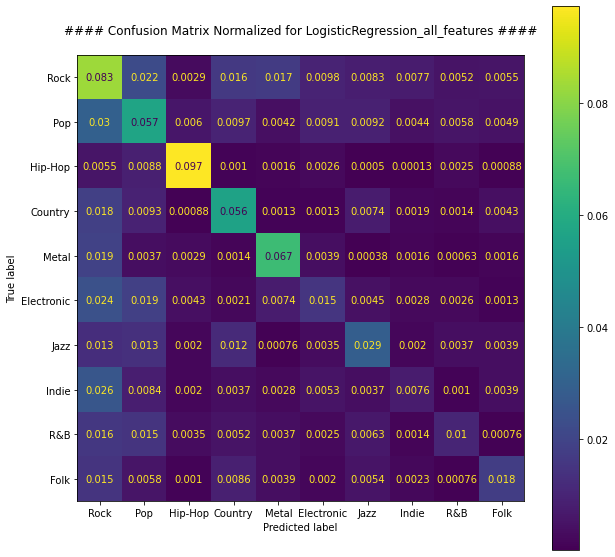

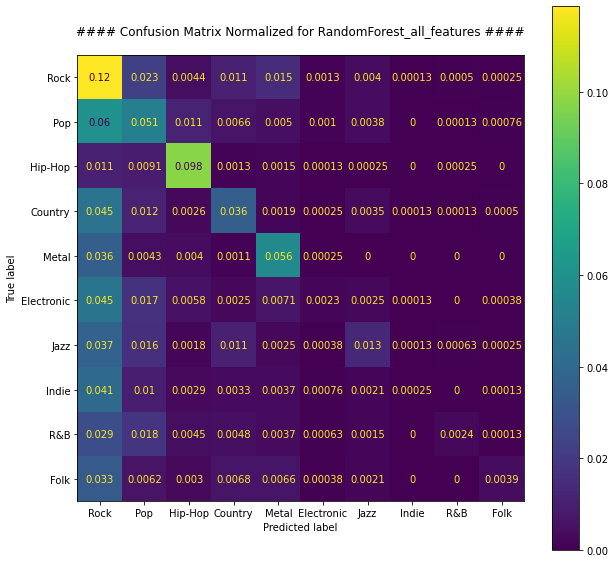

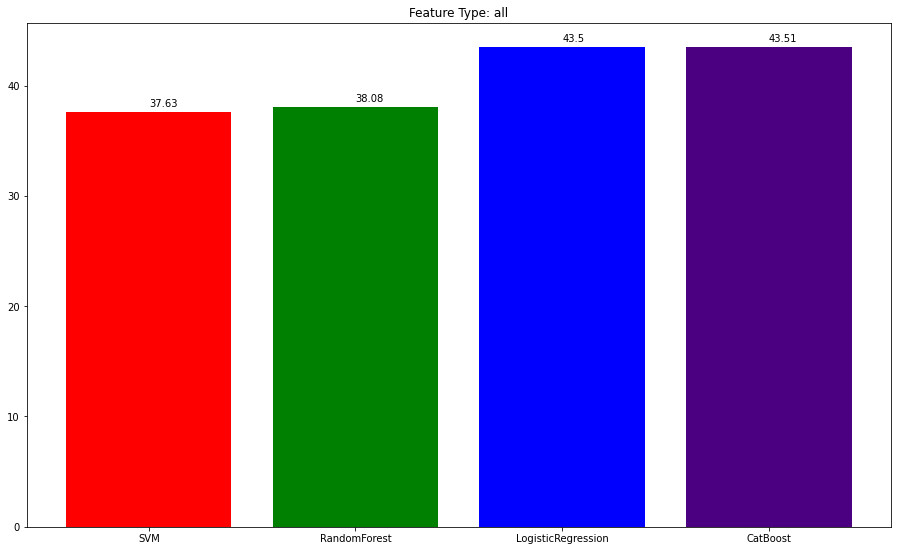

In [ ]:
performance = perform_exhaustive_training(train_data=train_all_features, train_labels=train_labels, test_data=test_all_features, test_labels=test_labels, features_type="all", no_folds=NO_FOLDS, print_confusion_matrix=PRINT_CONFUSION_MATRIX)
PERFORMANCE.update(performance)

## *Hyperparameters Tuning*

Tune the best model which was Logistic Regression / CatBoost againt the aggregation data. For training simplicity, LR was chosen.

In [53]:

from sklearn.model_selection import GridSearchCV

def create_gridsearch():
    model = LogisticRegression()
    #create the grid
    grid_parameters = {"penalty": ["l1", "l2"], "C": [0.1, 0.5, 1., 5.], "max_iter": [1000]}

    #Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=grid_parameters, scoring='accuracy', cv=3)

    #fit the model
    grid_search.fit(train_all_features, train_labels)

    print(grid_search.best_estimator_)

    best_model = grid_search.best_estimator_
    test_predicted = best_model.predict(test_all_features)
    accuracy = round(accuracy_score(test_predicted, test_labels) * 100, 2)
    print("Best model using gridSearch: {}".format(accuracy))

create_gridsearch()

LogisticRegression(C=0.5, max_iter=1000)
Best model using gridSearch: 45.09


# **Deep Learning Models (with word embeddings)**

## *HybridCNN (Convolutional Character + Word Neural Network)*

The architecture consists of two parts (which can be discarded during training):
* A character-level CNN
* A word-level CNN

1. The first part is described perfectly here: https://arxiv.org/pdf/1509.01626.pdf . The vocabulary of characters is selected based on the frequency of these characters (the most rare are discarded to reduce vocabulary size). More specifically, for a character to be considered part of the vocabulary, the number of its occurrences must be bigger than a minimum threshold (customizable).

2. The idea to consider the word-level CNN arise from the fact that maybe position of multiple words combined can be relevant to create useful features (the order of words can be important in some regions). In order to reduce the dimension of the vocabulary, each word was mapped to its stemmed conversion in the dictionary (meaning that the dictionary contains only stemmed words as keys). Also, for a word to be considered part of the vocabulary, the number of its occurrences must be bigger than a minimum threshold (which is again customizable).

In [39]:
PADDING_KEY, UNKNOWN_KEY = "<<<1234567890PADDING>>>", "<<<1234567890UNKNOWN>>>"

# clean text. This is a little bit different than our previous sanitize method, as we 
# might want to allow non-ascii values (unicode) to be present in the dictionaries.
def clean_text(document, remove_non_characters):
    # to lower-case
    res = document.lower()
    # replace punctuation with blank space
    res = "".join([chr if chr not in PUNCTUATION else ' ' for chr in res])
    if remove_non_characters:
        # replace non-characters with blank space
        res = re.sub(r"[^A-Za-zÀ-ž0-9]", ' ', res)
    else:
        # Add spaces before and after for all non-characters (for emojis)
        res = re.sub(r"[^A-Za-zÀ-ž0-9]", ' \\g<0> ', res)
    # Delete multiple spaces
    res = re.sub(r'\s+', ' ', res)

    # tokenize
    res = word_tokenize(res)
    # remove stop-words
    res = [word for word in res if word not in ENGLISH_STOPWORDS]
    # remove punctuation
    res = [word for word in res if word not in PUNCTUATION]
    # remove words that contain both characters and special characters (e.g: aa11bb)
    res = [word for word in res if not(word.isalnum() and not word.isalpha() and not word.isnumeric())]

    return " ".join(res)

# print mean and std of a corpus based on the frequency of the characters and words per document/tweet
def get_statistics(data, dataset_name):
    mean_len = np.mean([len(data[i][0]) for i in range(len(data))])
    std_len = np.std([len(data[i][0]) for i in range(len(data))])
    mean_words = np.mean([len(data[i][1]) for i in range(len(data))])
    std_words = np.std([len(data[i][1]) for i in range(len(data))])
    print("[{}] mean_len => {}, std => {}".format(dataset_name, mean_len, std_len))
    print("[{}] mean_word => {}, std => {}".format(dataset_name, mean_words, std_words))


# clean an entire corpus (a list of documents/tweets)
def clean_corpus(corpus, remove_non_characters=True):
    res = [clean_text(text, remove_non_characters) for text in corpus]
    return res


# split a document/tweet into words. Remove stopwords
def split_into_words(text):
    words = word_tokenize(text)
    words = [STEMMER.stem(word) for word in words]
    words = [word for word in words if word not in ENGLISH_STOPWORDS]
    return words


# construct a vocabulary based on the given corpus
# in order for a token to be added to this vocabulary, it's frequency must surpass a certain threshold
def construct_vocabulary(corpus, min_threshold):
    frequency_dict = {}
    for tokens in corpus:
        for token in tokens:
            frequency_dict[token] = frequency_dict.get(token, 0) + 1

    dictionary = {PADDING_KEY: 1, UNKNOWN_KEY: 2}
    for token in frequency_dict:
        if frequency_dict[token] >= min_threshold:
            dictionary[token] = len(dictionary) + 1

    print("dictionary has size: {}".format(len(dictionary)))
    return dictionary

# converts a list of tokens to their corresponding indexes inside a dictionary
# it also does a PADDING (when the number of tokens < total_length)
# or a TRUNCATION (when the number of tokens > total_length by choosing from
# the first total_length - select_last tokens and the last select_last tokens)
def convert_to_idx_helper(data, dictionary, total_length, select_last):
    if len(data) > total_length:
        return [dictionary[chr] if chr in dictionary else dictionary[UNKNOWN_KEY] for chr in
                data[: total_length - select_last] + data[-select_last:]]
    else:
        return [dictionary[chr] if chr in dictionary else dictionary[UNKNOWN_KEY] for chr in
                data] + [dictionary[PADDING_KEY]] * (total_length - len(data))

Split train into train + validation. Additionally, clean the data. 

In [40]:
# Split into train _ validation
train_dataframe, validation_dataframe = train_test_split(train_df, test_size=0.15, random_state=42)

# Clean corpus
train_features = clean_corpus(train_dataframe["Lyrics"])
validation_features = clean_corpus(validation_dataframe["Lyrics"])
test_features = clean_corpus(test_df["Lyrics"])

# Split each sample into words
train_features = [[sample, split_into_words(sample)] for sample in train_features]
validation_features = [[sample, split_into_words(sample)] for sample in validation_features]
test_features = [[sample, split_into_words(sample)] for sample in test_features]

Compute Words and Characters dictionaries. To calculate the ranges for the characters and words that will be used by our model (as these must be fix-sized), we compute `mean` and `std` for each such case and allow a maximum of `mean + std` for each.

In [41]:
CHAR2IDX_DICTIONARY = construct_vocabulary([train_features[i][0] for i in range(len(train_features))], min_threshold=10)
WORD2IDX_DICTIONARY = construct_vocabulary([train_features[i][1] for i in range(len(train_features))], min_threshold=10)

print(CHAR2IDX_DICTIONARY)
print(WORD2IDX_DICTIONARY)

get_statistics(train_features, dataset_name="train")
get_statistics(validation_features, dataset_name="validation")
get_statistics(test_features, dataset_name="test")

dictionary has size: 53
dictionary has size: 8839
{'<<<1234567890PADDING>>>': 1, '<<<1234567890UNKNOWN>>>': 2, 'd': 3, 'r': 4, 'o': 5, 'v': 6, 'e': 7, ' ': 8, 'n': 9, 'i': 10, 'g': 11, 'h': 12, 't': 13, 'a': 14, 'l': 15, 'f': 16, 'x': 17, 'y': 18, 'm': 19, 'u': 20, 's': 21, 'p': 22, 'c': 23, 'k': 24, 'b': 25, 'w': 26, 'z': 27, 'j': 28, 'q': 29, '1': 30, '2': 31, '7': 32, '3': 33, '0': 34, '8': 35, '5': 36, '4': 37, '9': 38, '6': 39, 'ï': 40, 'ã': 41, 'í': 42, 'ë': 43, 'ê': 44, 'ì': 45, 'â': 46, 'é': 47, 'ä': 48, 'å': 49, 'æ': 50, 'ç': 51, 'è': 52, 'à': 53}
{'<<<1234567890PADDING>>>': 1, '<<<1234567890UNKNOWN>>>': 2, 'drove': 3, 'night': 4, 'half': 5, 'next': 6, 'day': 7, 'mountain': 8, 'open': 9, 'space': 10, 'got': 11, 'search': 12, 'thank': 13, 'carri': 14, 'box': 15, 'help': 16, 'told': 17, 'old': 18, 'colleg': 19, 'stori': 20, 'laugh': 21, 'tear': 22, 'start': 23, 'fall': 24, 'ran': 25, 'time': 26, 'could': 27, 'avoid': 28, 'goodby': 29, 'said': 30, 'wish': 31, 'stay': 32, 'hard': 

The config file used in training

In [42]:
hybridCNN_config = {
  "epochs": 40,

  "remove_non_characters": True,
  "threshold_characters_vocabulary": 5,
  "threshold_words_vocabulary": 5,

  "character_level_CNN": True,
  "word_level_CNN": True,

  "learning_rate_decay": 1.0,
  "initial_lr": 0.001,

  "weight_decay": 0.0,
  "dropout": 0.1,
  "gaussian_noise": 0.0,
  "spatial_dropout": 0.1,

  "task_type": "classification",
  "loss": "categorical_crossentropy",

  "total_characters": 1000,
  "select_last_characters": 500,
  "total_words": 200,
  "select_last_words": 100
}

# method to convert the data into a proper form to be fed to the model
def convert(data_list, data_labels):
    def convert_char2idx(data):
        return convert_to_idx_helper(data=data,
                                  dictionary=CHAR2IDX_DICTIONARY,
                                  total_length=hybridCNN_config["total_characters"],
                                  select_last=hybridCNN_config["select_last_characters"])

    def convert_word2idx(data):
        # use stemmer for each word rather than the actual word
        return convert_to_idx_helper(data=[STEMMER.stem(word) for word in data],
                                  dictionary=WORD2IDX_DICTIONARY,
                                  total_length=hybridCNN_config["total_words"],
                                  select_last=hybridCNN_config["select_last_words"])

    charFX = np.asarray([convert_char2idx(data[0]) for data in data_list])
    wordFX = np.asarray([convert_word2idx(data[1]) for data in data_list])

    data_labels = np.asarray(data_labels)
    data_labels = np.eye(len(genre_mappings))[data_labels]
    return [charFX, wordFX], data_labels

# Prepare the features and the labels for the model train
train_input, train_labels = convert(train_features, train_dataframe["label"])
validation_input, validation_labels = convert(validation_features, validation_dataframe["label"])
test_input, test_labels = convert(test_features, test_df["label"]) # [] is for consistency, not important
print("### Train features size: {}".format(len(train_features)))
print("### Validation features size: {}".format(validation_input[0].shape))

### Train features size: 15736
### Validation features size: (2777, 1000)


Design the model 

In [43]:
import tensorflow_addons as tfa

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Embedding, Concatenate, Input, Dense, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, GaussianNoise, SpatialDropout1D

class CharCNNTrainer(object):
    def __init__(self, alphabet_characters_length, alphabet_words_length, config, no_classes=None):

        # the length of the alphabets (charAlphabet and wordAlphabet)
        self.alphabet_characters_length = alphabet_characters_length
        self.alphabet_words_length = alphabet_words_length

        # total numbers of characters/words per tweet (PADDING or TRUNCATION might be applied)
        self.total_characters = config["total_characters"]
        self.total_words = config["total_words"]

        # regularization techniques
        self.initial_lr = config["initial_lr"]
        self.weight_decay = config["weight_decay"]
        self.dropout = config["dropout"]
        self.gaussian_noise = config["gaussian_noise"]
        self.spatial_dropout = config["spatial_dropout"]

        # loss function
        self.loss = config["loss"]

        # 2 submodels at different levels: character level and word level
        # Is used to enable training on each of them or only one of them
        self.character_level_CNN = config["character_level_CNN"]
        self.word_level_CNN = config["word_level_CNN"]

        # assert there is at least one of the submodels active
        assert (self.character_level_CNN or self.word_level_CNN)

        # number of classes. Is not relevant during regression
        self.no_classes = no_classes

        # the embedding size of each dictionary
        self.embedding_characters_dimension = 128
        self.embedding_words_dimension = 128

        # the convolutional layers at character level
        self.convolutional_layers_characters = [
            [[256, 9, "relu"], 3],
            [[192, 7, "relu"], 3],
            [[128, 5, "relu"], 3]
        ]

        # the convolutional layers at word level
        self.convolutional_layers_words = [
            [[256, 7, "relu"], 2],
            [[192, 5, "relu"], 2],
            [[128, 3, "relu"], 2]
        ]

        # the fully connected layers at each level. Used to map the flatten of each last convolutional output.
        # from practice is better to use the same values for both of them
        # (to not give one submodule more importance)
        self.fully_connected_characters = [128, "relu"]
        self.fully_connected_words = [128, "relu"]

        # the final fully connected layers
        self.fully_connected_final = [
            [256, "relu"],
            [128, "relu"],
            [64, "relu"]
        ]

        self._create_model()

    def _create_model(self):

        output_characters, output_words = None, None

        ####### Character Level ######

        # Input layer
        input_characters = Input(shape=(self.total_characters,), name='input_characters', dtype='int64')

        if self.character_level_CNN:
            res_characters = Embedding(self.alphabet_characters_length + 1, self.embedding_characters_dimension,
                               input_length=self.total_characters)(input_characters)
            res_characters = Reshape((self.total_characters, self.embedding_characters_dimension))(res_characters)

            # Convolutional layers
            for cl in self.convolutional_layers_characters:
                # Convolutional layer
                res_characters = Conv1D(cl[0][0], cl[0][1], padding="same", activation=cl[0][2])(res_characters)

                # Max Pooling
                if cl[1] > 0:
                    res_characters = MaxPooling1D(cl[1], cl[1])(res_characters)

                # Apply regularization techniques: GaussianNoise and spatialDropout
                if self.gaussian_noise > 0:
                    res_characters = GaussianNoise(stddev=self.gaussian_noise)(res_characters)
                if self.spatial_dropout > 0:
                    res_characters = SpatialDropout1D(rate=self.spatial_dropout)(res_characters)

            # Flatten the features
            res_characters = GlobalAveragePooling1D()(res_characters)
            output_characters = Dense(self.fully_connected_characters[0], activation=self.fully_connected_characters[1])(res_characters)


        ####### Word Level #######

        # Input layer
        input_words = Input(shape=(self.total_words,), name='input_words', dtype='int64')

        if self.word_level_CNN:
            res_words = Embedding(input_dim=self.alphabet_words_length + 1, output_dim=self.embedding_words_dimension,
                               input_length=self.total_words)(input_words)
            res_words = Reshape((self.total_words, self.embedding_words_dimension))(res_words)


            # Convolutional blocks
            for cl in self.convolutional_layers_words:
                # Convolutional layer
                res_words = Conv1D(cl[0][0], cl[0][1], padding="same", activation=cl[0][2])(res_words)

                # Max Pooling
                if cl[1] > 0:
                    res_words = MaxPooling1D(cl[1], cl[1])(res_words)

                # Apply regularization techniques: GaussianNoise and spatialDropout
                if self.gaussian_noise > 0:
                    res_words = GaussianNoise(stddev=self.gaussian_noise)(res_words)
                if self.spatial_dropout > 0:
                    res_words = SpatialDropout1D(rate=self.spatial_dropout)(res_words)

            res_words = GlobalAveragePooling1D()(res_words)
            output_words = Dense(self.fully_connected_words[0], activation=self.fully_connected_words[1])(res_words)

        ####### Concatenate outputs #######

        outputs_list = [output for output in [output_characters, output_words] if output != None]

        res = Concatenate(axis=1)(outputs_list) if len(outputs_list) == 2 else outputs_list[0]

        # Final fully connected layers
        for [fl, activation_flag] in self.fully_connected_final:
            res = Dense(fl, activation=activation_flag)(res)

            # Apply dropout
            if self.dropout > 0:
                res = Dropout(self.dropout)(res)

        predictions = Dense(self.no_classes, activation="softmax")(res)
        self.metrics = ['accuracy']

        # Build and compile the models
        model = Model(inputs=[input_characters, input_words], outputs=predictions)
        optimizer = tfa.optimizers.AdamW(learning_rate=self.initial_lr, weight_decay=self.weight_decay)

        model.compile(optimizer=optimizer, loss=self.loss, metrics=self.metrics)

        self.model = model
        self.model.summary()

Start the actual training and record the results

In [44]:
# Instantiates a trainer
trainer = CharCNNTrainer(alphabet_characters_length=len(CHAR2IDX_DICTIONARY),
                         alphabet_words_length=len(WORD2IDX_DICTIONARY),
                         config=hybridCNN_config,
                         no_classes=len(genre_mappings))

# Compute class weights.
class_weight = Counter(np.argmax(train_labels, axis=1))
total = np.sum(list(class_weight.values()))
for key in class_weight:
   class_weight[key] = (total / class_weight[key]) * (1 / len(genre_mappings))

history = trainer.model.fit(train_input,
                            train_labels,
                            validation_data=(validation_input, validation_labels),
                            shuffle=True,
                            batch_size=96,
                            epochs=hybridCNN_config["epochs"],
                            verbose=1,
                            class_weight=class_weight)
results = trainer.model.evaluate(test_input, test_labels, verbose=0)
PERFORMANCE["hybridCNN"] = results[1] * 100
print("#### HybridCNN performance: {}".format(PERFORMANCE["hybridCNN"]))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_characters (InputLayer)  [(None, 1000)]       0           []                               
                                                                                                  
 input_words (InputLayer)       [(None, 200)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1000, 128)    6912        ['input_characters[0][0]']       
                                                                                                  
 embedding_5 (Embedding)        (None, 200, 128)     1131520     ['input_words[0][0]']            
                                                                                            

## *Transformers*

We will take `bert-base-uncased` pretrained and finetune for our classification task accordingly.


In [45]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TrainingArguments, Trainer

def create_corpus_transformer(tokenizer, df_train, df_test):
    train_dataframe, validation_dataframe = train_test_split(df_train, test_size=0.15, random_state=42)
    test_dataframe = df_test
    
    train_features = tokenizer(train_dataframe["Lyrics"].tolist(), padding="max_length", truncation=True, return_tensors="np")
    validation_features = tokenizer(validation_dataframe["Lyrics"].tolist(), padding="max_length", truncation=True, return_tensors="np")
    test_features = tokenizer(test_dataframe["Lyrics"].tolist(), padding="max_length", truncation=True, return_tensors="np")
    res = {}

    res["train"] = (dict(train_features), np.asarray(train_dataframe["label"]))
    res["validation"] = (dict(validation_features), np.asarray(validation_dataframe["label"])) 
    res["test"] = (dict(test_features), np.asarray(test_dataframe["label"]))
    return res

transformer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(transformer_name)
model = TFAutoModelForSequenceClassification.from_pretrained(transformer_name, num_labels=len(genre_mappings))
print("#### Transformer Summary #####\n")
print(model.summary())
corpus = create_corpus_transformer(tokenizer=tokenizer, df_train=train_df, df_test=test_df)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Transformer Summary #####

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_46 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 109,489,930
Trainable params: 109,489,930
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
# Prepare the optinizer, the loss function and the metrics to watch during training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

# Fit the model
model.fit(corpus["train"][0], corpus["train"][1], validation_data=(corpus["validation"][0], corpus["validation"][1]), batch_size=10, epochs=4, verbose=1)

Epoch 1/4
1574/1574 [==============================] - 1210s 757ms/step - loss: 0.4473 - sparse_categorical_accuracy: 0.8610 - val_loss: 2.3807 - val_sparse_categorical_accuracy: 0.4483
Epoch 2/4
1574/1574 [==============================] - 1189s 755ms/step - loss: 0.2840 - sparse_categorical_accuracy: 0.9134 - val_loss: 2.6254 - val_sparse_categorical_accuracy: 0.4375
Epoch 3/4
1574/1574 [==============================] - 1189s 755ms/step - loss: 0.2175 - sparse_categorical_accuracy: 0.9338 - val_loss: 2.9465 - val_sparse_categorical_accuracy: 0.4094
Epoch 4/4
1574/1574 [==============================] - 1189s 755ms/step - loss: 0.1787 - sparse_categorical_accuracy: 0.9464 - val_loss: 2.7586 - val_sparse_categorical_accuracy: 0.4235


Test the trained model against the train set. Obtained around 43.8%, which is almost the same as the method using CatBoost / Logistic Regression against all features (default).



In [47]:
print("##### Accuracy on Test Set")
result = model.evaluate(corpus["test"][0], corpus["test"][1], batch_size=10)
PERFORMANCE["Bert_finetuned"] = result[1] * 100

##### Accuracy on Test Set
794/794 [==============================] - 195s 246ms/step - loss: 1.9187 - sparse_categorical_accuracy: 0.4383


# **Final Comparison**

As we can see, the best approach is the finetuned version of Logistic Regression against all the features (**45.09**%), followed by the Bert-finetuned model (**43.8**%). This is followed closely by LR and CatBoost, both using the aggregation of all features with default parameters (**43.5**%). Right after is the SVM and LR, both using dense representation from pretrained transfomer.

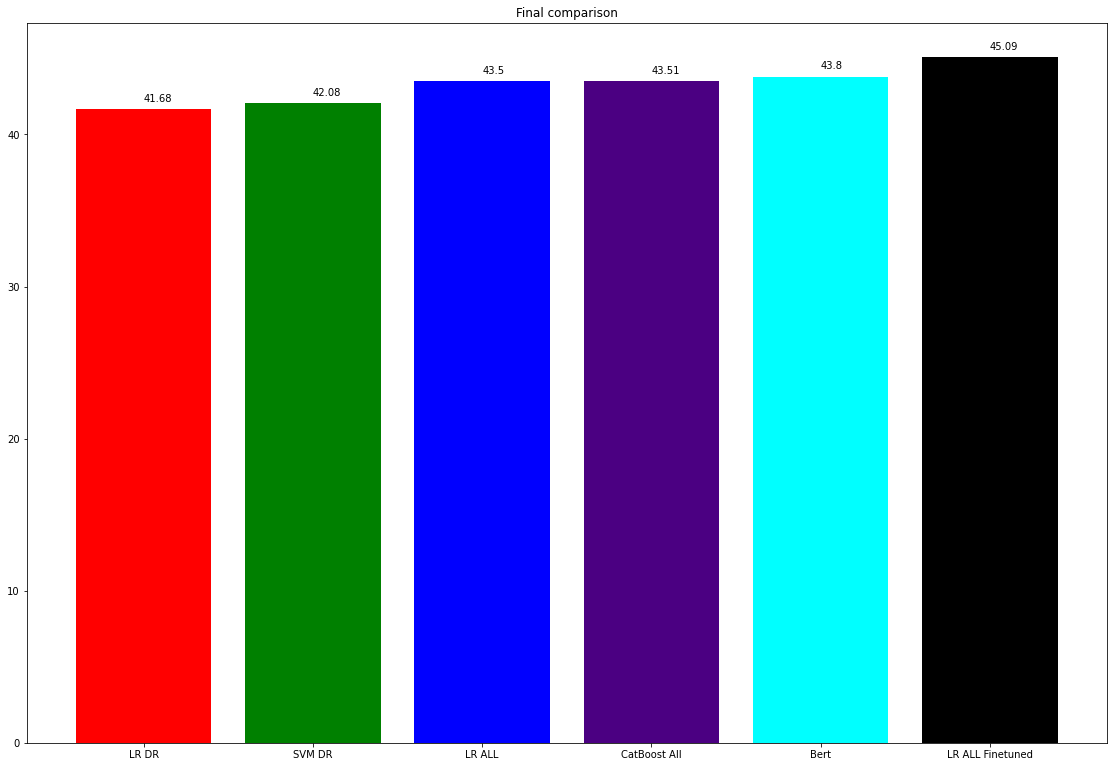

In [52]:
final_results = [(k, v) for k, v in sorted(PERFORMANCE.items(), key=lambda item: item[1])][-6:]

keys = [x[0] for x in final_results]
values = [x[1] for x in final_results]
plot_barchart_custom(keys, values, title="Final comparison", fig_size=(15, 10))

# **Conclusion and Future Agenda**

**Conclusions**
* Four different types of features (musical, sentence transformer, FastText and BOW) were tried, plus an additional type that aggregates three of these features. The best ones were those that used sentence embeddings from transformers.
* The final results indicate that **Logistic Regression**(**C=0.5**) is the best model, with a performance of **45.09**%, followed by Bert fine-tuned at around **43.8**% (trained for just *8* epochs). Immediately after are the LR and CatBoost trained on all features with default parameters, with a performance of **43.5**% each). Nevertheless, the other approaches obtain very good results, especially the one using sentence embedding (around **42**% and go up to almost **44**% when used in conjunction with other features).
* Adding musical features on top of contextual ones plus **BOW** offers a boost in performance, which shows the importance of the rhythm and rhyme of the lyrics when predicting a musical genre. 
* The *hybridCNN* did not managed to come close to the best trained models, but this may be due to not properly finetuning the model (it is known that Deep Learning models are more prone to easily overfit than shallow models when using default parameters).
* Even though the actual lyrics partially encode a melody, there are other things to be considered (the rhythm of the singer, the pronunciation, etc).This introduce a bias that is very hard to overcome just by simply looking at the raw text alone. 
* As for training goes, we did tried both `balanced` class_weights as well as the default one, but the results proved to be better with the latter.
* For each experiment, we used a 3-fold cross validation (5 was used at times, but training 4 models for 5 types of features would have taken too much). The results seem to remain consistent though, regardless of the number of folds.


*Future Agenda*: 
* For each type of feature, choose the best model from CV and fine-tune its parameters.
* Implement a `hierarchical model` to first predict some clusters of genres, and internally to have other models that predict the final type (which might be different architectures for each cluster).
* Augment the data from other sources (although the requirement from the task did not allow us to do this).
* Use other metadata: for instance there are tools to extract audio features: e.g. `librosa` or check for precomputed features (e.g. using `spotify`, `echonest`).
* Using the name of an Artist as well (since an artist usually account for only one genre, or maybe two). This can provide useful information about the text.